# Numba / Dev Reinforcement learning framework

This notebook gathers the functions creating different kinds of environments for foraging and target search in various scenarios.

In [ ]:
raise('skip_exec not working!')

In [ ]:
#| default_exp rl_framework.dev

#| hide
# Libs

In [ ]:
#| export
import numpy as np
import numba
from numba.experimental import jitclass
from numba import jit, float64, int64, bool_, prange, njit
import math
import random

In [ ]:
#| hide
import matplotlib.pyplot as plt

# Helpers

## isBetween

In [ ]:
# |export
@njit
def isBetween_c_Vec_numba(a, b, c, r):
        """
        Checks whether point c is crossing the line formed with point a and b.

        Parameters
        ----------
        a : tensor, shape = (1,2)
            Previous position.
        b : tensor, shape = (1,2)
            Current position.
        c : tensor, shape = (Nt,2)
            Positions of all targets.
        r : int/float
            Target radius.

        Returns
        -------
        mask : array of boolean values
            True at the indices of found targets.

        """
        if (a == b).all():
            return np.array([False]*c.shape[0])

        mask = np.array([True]*c.shape[0])
        
        dotproduct = (c[:, 0] - a[0]) * (b[0] - a[0]) + (c[:, 1] - a[1])*(b[1] - a[1])
        squaredlengthba = (b[0] - a[0])*(b[0] - a[0]) + (b[1] - a[1])*(b[1] - a[1])
        
        #exclude the targets whose vertical projection of the vector c-a w.r.t. the vector b-a is larger than the target radius.
        idx = np.argwhere(np.abs(numba.np.arraymath.cross2d(b-a, c-a))/np.linalg.norm(b-a) > r) 
        for i1 in idx:
            mask[i1] = False        
        
        #exclude the targets whose scalar product is negative (they are on the other side of the step direction)
        for i2 in np.argwhere(dotproduct < 0):
            mask[i2] = False

        #exclude the targets that are beyond the step.
        for i3 in np.argwhere(dotproduct > squaredlengthba):
            mask[i3] = False
            
        return mask

In [ ]:
compiling = isBetween_c_Vec_numba(np.array([0.1,1]), np.array([1,3]), np.random.rand(100,2), 0.00001)

In [ ]:
%timeit isBetween_c_Vec_numba(np.array([0.1,1]), np.array([1,3]), np.random.rand(100,2), 0.00001)

4.48 µs ± 16.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [ ]:
from rl_opts.utils import isBetween_c_Vec as oldbetween

In [ ]:
%timeit oldbetween(np.array([0.1,1]), np.array([1,3]), np.random.rand(100,2), 0.00001)

46.9 µs ± 442 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Pareto sampling

In [ ]:
# |export
@njit
def pareto_sample(alpha, xm, size=1):
    samples = np.zeros(size)
    for ii in range(size):
        u = random.random()  # Uniform random variable between 0 and 1
        x = xm / (u ** (1 / alpha))
        samples[ii] = x
    return samples

## Random sampling from array with probs

In [ ]:
# |export
@njit
def rand_choice_nb(arr, prob):
    """
    :param arr: A 1D numpy array of values to sample from.
    :param prob: A 1D numpy array of probabilities for the given samples.
    :return: A random sample from the given array with a given probability.
    """
    return arr[np.searchsorted(np.cumsum(prob), np.random.random(), side="right")]

# Environments

## TargetEnv

In [ ]:
#|export
@jitclass([("target_positions", float64[:,:]) ,
           ("current_rewards", float64[:]) ,
           ("kicked", float64[:]) ,
           ("current_directions", float64[:]) ,
           ("positions", float64[:,:]),
           ("previous_pos", float64[:,:]),
           ("lc", float64[:,:]),
           ("mask", bool_[:]),
           ("first_encounter", float64[:,:])])
class TargetEnv():
    Nt : int
    L : float
    r : float
    lc : np.array
    agent_step : float
    num_agents : int
    destructive_targets : bool
    target_positions : np.ndarray
    current_rewards : np.array
    kicked : np.array
    current_directions : np.array
    positions : np.array
    previous_pos : np.array
    mask : np.array
    first_encounter : np.array
    lc_distribution : str
    
    
    def __init__(self,
                 Nt = 10,
                 L = 1.3,
                 r = 1.5,
                 lc = np.array([[1.0],[1]]),
                 agent_step = 1,
                 num_agents = 1,
                 destructive = False,
                 lc_distribution = 'constant'):
        
        """Class defining the foraging environment. It includes the methods needed to place several agents to the world.
        
        Parameters
        ----------
        Nt: int 
            Number of targets.
        L: int
            Size of the (squared) world.
        r: int 
            Radius with center the target position. It defines the area in which agent detects the target.
        lc: CHANGE!
            Cutoff length. Displacement away from target (to implement revisitable targets by displacing agent away from the visited target).
        agent_step: int, optional 
            Displacement of one step. The default is 1.
        num_agents: int, optional 
            Number of agents that forage at the same time. The default is 1.
        destructive: bool, optional
            True if targets are destructive. The default is False.
        """
        self.Nt = Nt
        self.L = L
        self.r = r
        self.lc = lc
        self.agent_step = agent_step 
        self.num_agents = num_agents
        self.destructive_targets = destructive
        self.lc_distribution = lc_distribution
        

        self.init_env()
        
    def init_env(self):
        """
        Environment initialization.
        """
        self.target_positions = np.random.rand(self.Nt, 2)*self.L
        
        #store who is/was rewarded
        self.current_rewards = np.zeros(self.num_agents)
        
        #signal whether agent has been kicked
        self.kicked = np.zeros(self.num_agents)
        
        #set positions and directions of the agents
        self.current_directions = np.random.rand(self.num_agents)*2*np.pi
        self.positions = np.random.rand(self.num_agents, 2)*self.L
        self.previous_pos = self.positions.copy()       

        

    def update_pos(self, change_direction):        
        """
        Updates information of the agent depending on its decision.

        Parameters
        ----------
        change_direction : bool
            Whether the agent decided to turn or not.
        agent_index : int, optional
            Index of the given agent. The default is 0.
        """
        agent_index = 0
        # Save previous position to check if crossing happened
        self.previous_pos[agent_index] = self.positions[agent_index].copy()
        
        if change_direction:
            self.current_directions[agent_index] = random.uniform(0,1)*2*math.pi
        
        #Update position
        self.positions[agent_index][0] = self.positions[agent_index][0] + self.agent_step*np.cos(self.current_directions[agent_index])
        self.positions[agent_index][1] = self.positions[agent_index][1] + self.agent_step*np.sin(self.current_directions[agent_index])
        
       
    def check_encounter(self):
        """
        Checks whether the agent found a target, and updates the information accordingly.

        Parameters
        ----------
        agent_index : int, optional

        Returns
        -------
        True if the agent found a target.

        """       
        agent_index=0
        encounters = isBetween_c_Vec_numba(self.previous_pos[agent_index], self.positions[agent_index], self.target_positions, self.r)
        
        if sum(encounters) > 0: 
            
            #if there is more than 1 encounter, pick the closest to the agent.
            if sum(encounters) == 1:
                first_encounter = np.argwhere(encounters == True).flatten()
            else:
                # compute the distance from the previous position to each target            
                distance_previous_pos = np.sqrt((self.previous_pos[agent_index][0]- self.target_positions[:, 0])**2 + (self.previous_pos[agent_index][1] - self.target_positions[:, 1])**2)            
                
                # checking which encountered point is closer to previous position
                min_distance_masked = np.argmin(distance_previous_pos[encounters])
                first_encounter = np.argwhere(encounters == True)[min_distance_masked].flatten()
            if self.destructive_targets:
                self.target_positions[first_encounter] = np.random.rand(2)*self.L
            else:
                #----KICK----
                # If there was encounter, we reset direction and change position of particle to (pos target + lc)
                kick_direction = np.random.uniform(low = 0, high = 2*np.pi)
                for idx_first in first_encounter: # This is super weird!
                    if self.lc_distribution == 'power_law':
                        # when we have the power law, the first value of lc is considered to be the exponent.
                        # The following samples from a power law x^{-1-alpha} where alpha = self.lc.flatten()[0]                        
                        current_lc = (1-random.uniform(0,1))**(-1/self.lc.flatten()[0])

                    elif self.lc_distribution == 'pareto':
                        # Sampling from Pareto. Here alpha = self.lc.flatten()[0] and x_minim = self.lc.flatten()[0]
                        current_lc = pareto_sample(self.lc[0,0], self.lc[1,0])[0]
                    else:
                        # if lc has a single element, take that one as lc, if not sample
                        current_lc = self.lc.flatten()[0] if len(self.lc.flatten()) == 2 else rand_choice_nb(arr = self.lc[0], prob = self.lc[1])
                    self.positions[agent_index][0] = self.target_positions[idx_first, 0] + current_lc*np.cos(kick_direction)
                    self.positions[agent_index][1] = self.target_positions[idx_first, 1] + current_lc*np.sin(kick_direction)
                self.kicked[agent_index] = 1
                #------------
                
            #...and we add the information that this agent got to the target
            self.current_rewards[agent_index] = 1              
            return 1
        
        else: 
            self.kicked[agent_index] = 0
            self.current_rewards[agent_index] = 0
            return 0   
        
    def check_bc(self):
        """
        Updates position coordinates of agent agent_index to fulfill periodic boundary conditions.

        """
        agent_index=0
        self.positions[agent_index] = (self.positions[agent_index])%self.L
    

#### Runtime testing 

In [ ]:
env = TargetEnv(Nt = 1000,
                 L = 123,
                 r = 50,
                 lc = np.array([[0.1],[1]]),
                 lc_distribution = 'pareto')
compiling = env.check_encounter()

In [ ]:
%timeit env.check_encounter()

15.5 µs ± 892 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
env = TargetEnv(Nt = 1000,
                 L = 123,
                 r = 50,
                 lc = np.array([[0.1, 0.3, 0.5, 0.5],[0.8, 0.1, 0.05, 0.05]]))
compiling = env.check_encounter()

In [ ]:
%timeit env.check_encounter()

12 µs ± 7.38 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [ ]:
from rl_opts.rl_framework.legacy import TargetEnv as oldEnv

In [ ]:
oenv = oldEnv(Nt = 100,
                 L = 123,
                 r = 0.2,
                 lc = 1)

In [ ]:
%timeit oenv.check_encounter()

/home/gorka/github/fork_rl_opts/rl_opts/utils.py:36: RuntimeWarning: invalid value encountered in divide
  mask[np.argwhere(np.abs(np.cross(b-a, c-a))/np.linalg.norm(b-a) > r)] = False


232 µs ± 388 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
@jitclass
class move():
    env : TargetEnv

    def __init__(self,
                 Nt = 1000,
                 L = 123.0,
                 r = 0.2,
                 lc = 1.0,
                 TIME_EP = 10):

        self.env = TargetEnv(Nt, L, r, np.array([[0.1, 0.3, 0.5, 0.5],[0.8, 0.1, 0.05, 0.05]]), 1, 1, False, 'power_law')
    
    def run(self, t):
        for time in range(t):
            self.env.update_pos(False)
            self.env.check_encounter()
            self.env.check_bc()
            

In [ ]:
k = move()
onerun = k.run(5)

In [ ]:
%timeit k.run(10000)

123 ms ± 61.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
from rl_opts.rl_framework.legacy import TargetEnv as oldEnv

In [ ]:
oenv = oldEnv(Nt = 1000,
                 L = 123,
                 r = 0.2,
                 lc = 1)

In [ ]:
def old_run(t):
    for t in range(t):
        oenv.update_pos(False)
        oenv.check_encounter()
        oenv.check_bc()

In [ ]:
%timeit old_run(10000)

2.85 s ± 48.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Walk from policy

In [ ]:
#| export                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
@njit
def single_agent_walk(N_runs, time_ep, policy, env):  
    
    save_rewards = np.zeros(N_runs)
    
    for ep in range(N_runs):
        # print(f'starting episode {ep} for agent {n_agent}')
        #initialize environment and agent's counter and g matrix
        env.init_env()
        agent_state = 0

        for t in range(time_ep):
            
            if t == 0 or env.kicked[0]:
                # change direction
                env.update_pos(1)
                #check boundary conditions
                env.check_bc()
                #reset counter
                agent_state = 0
                #set kicked value to false again
                env.kicked[0] = 0
                
            else: 
                # decide
                action = 0 if policy[0, agent_state] > np.random.rand() else 1
                #update positions
                env.update_pos(action)
                #check if target was found + kick if it is
                reward = env.check_encounter()
                #check boundary conditions
                env.check_bc()
                # update agent_state
                agent_state += 1
                
                save_rewards[ep] += reward
                
    return save_rewards

In [ ]:
#| export
@njit(parallel = True)
def multi_agents_walk(N_runs, time_ep, N_agents,
               # Environment props
               Nt = 100,
               L = 100,
               r = 0.5,
               lc = np.array([[1.0],[1]]),
               num_agents = 1, 
               agent_step = 1,
               destructive_targets = False,
               lc_distribution = 'constant',
               # Agent props
               policy = np.array([[1]*100, [0]*100])
              ):
    
    save_rewards = np.zeros((N_agents, N_runs))
    
    for n_agent in prange(N_agents):
        
        env = TargetEnv(Nt,L,r,lc,agent_step,num_agents,destructive_targets,lc_distribution)
        
        rews = single_agent_walk(N_runs, time_ep, policy, env) 
    
        save_rewards[n_agent] = rews
        
    return save_rewards

## ResetEnv

### 1D

In [ ]:
#|export
@jitclass
class ResetEnv_1D():
    L : float
    D : float    
    position : float    
    
    def __init__(self,
                 L = 1.3,
                 D = 1.0,                    
                ):        
   
        self.L = L
        self.D = D
        self.position = 0
        
    def init_env(self):
        self.position = 0
    
    def update_pos(self, 
                   action # 0: continue walk, 1: reset to origin
                  ): # Reward = 1 if crossed L, else = 0
        
        if action == 0:
            self.position += np.random.randn()*np.sqrt(2*self.D)        
        else: self.position = 0
                
        if self.position >= self.L: 
            self.init_env()
            return 1
        else: return 0

In [ ]:
#|export

@njit
def reset_search_loop(T, reset_policy, env):
    
    rewards = 0
    tau = 0 # time since last reset
    
    for t in range(T):
        
        action = 0 if np.random.rand() > reset_policy[tau] else 1
        rew = env.update_pos(action = action)
        
        if rew == 1 or action == 1:
            tau = 0
        else:
            tau += 1
        
        rewards += rew
    
    return rewards

@njit(parallel = True)
def multi_loop_constant(T, resets, L, D):
    rews_reset = np.zeros_like(resets)
    
    for idxr in prange(len(resets)):
        
        env = ResetEnv_1D(L, D)        
        reset_policy = np.zeros(resets[idxr])
        reset_policy[resets[idxr]-1] = 1        
        
        rews_reset[idxr] = reset_search_loop(T = T, reset_policy = reset_policy, env = env)
    return rews_reset

@njit(parallel = True)
def multi_loop_exp(T, rates, L, D):
    
    rews_rate = np.zeros_like(rates)
    for idxr in prange(len(rates)):
        
        env = ResetEnv_1D(L, D)        
        reset_policy = np.ones(T)*rates[idxr]
        
        rews_rate[idxr] = reset_search_loop(T = T, reset_policy = reset_policy, env = env)
    return rews_rate

In [ ]:
L = 10.0; D = 1/2; T = int(1e3)

resets = np.linspace(70, 150, 40).astype(np.int64)

In [ ]:

%timeit multi_loop_constant(T, np.linspace(70, 150, 20).astype(np.int64), L, D)

121 µs ± 46.6 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:

%timeit multi_loop_constant(T, np.linspace(70, 150, 40).astype(np.int64), L, D)

112 µs ± 27.3 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### 2D

In [ ]:
#|export
@jitclass([("position", float64[:]),
           ("target_position", float64[:,:]),
           ("previous_pos", float64[:])
          ])
class ResetEnv_2D():
    D : float    
    dist_target :float
    r: float
    position : np.array    
    target_position : np.array
    previous_pos : np.array
    
    def __init__(self,
                 dist_target = 0.2, # Distance from init position and target
                 radius_target = 0.5, # Radius of the target
                 D = 1.0, # Diffusion coefficient of the walker              
                ):    
        

        self.D = D
        self.dist_target = dist_target
        self.r = radius_target        
        
        self.target_position = np.array([self.dist_target*np.cos(np.pi/4), self.dist_target*np.sin(np.pi/4)])[np.newaxis, :]       
        
        self.init_env()
        
    def init_env(self):
        self.position = np.array([0.0,0.0])
        self.previous_pos = self.position.copy()     
        
        
    
    def update_pos(self, 
                   action # 0: continue walk, 1: reset to origin
                  ): # Reward = 1 if encountered target, else = 0
        
        if action == 1:
            self.init_env()
            return 0
        
        elif action == 0:
            
            self.previous_pos = self.position.copy()            
            self.position += np.random.randn(2)*np.sqrt(2*self.D)
            
            # Checking encounter
            inside_target = np.linalg.norm(self.position-self.target_position) <= self.r
            crossed_target = isBetween_c_Vec_numba(self.previous_pos, self.position, self.target_position, self.r)
                        
            if inside_target or crossed_target:
                self.init_env()
                return 1
            else: 
                return 0
            
        

In [ ]:
#|export
@njit(parallel = True)
def multi_loop_constant_2D(T, resets, dist_target, radius_target, D):
    rews_reset = np.zeros_like(resets)
    
    for idxr in prange(len(resets)): 
        
        env = ResetEnv_2D(dist_target, radius_target, D)        
        reset_policy = np.zeros(resets[idxr])
        reset_policy[resets[idxr]-1] = 1        
        
        rews_reset[idxr] = reset_search_loop(T = T, reset_policy = reset_policy, env = env)
    return rews_reset



@njit(parallel = True)
def multi_loop_exp_2D(T, rates, dist_target, radius_target, D):
    
    rews_rate = np.zeros_like(rates)
    for idxr in prange(len(rates)):
        
        env = ResetEnv_2D(dist_target, radius_target, D)         
        reset_policy = np.ones(T)*rates[idxr]
        
        rews_rate[idxr] = reset_search_loop(T = T, reset_policy = reset_policy, env = env)
    return rews_rate

@njit(parallel = True)
def multi_loop_policies_2D(T, reset_policies, dist_target, radius_target, D):
    
    rews_rate = np.zeros(reset_policies.shape[0])    
    
    for idx_policy in prange(reset_policies.shape[0]):    
        
        env = ResetEnv_2D(dist_target, radius_target, D)  
                
        rews_rate[idx_policy] = reset_search_loop(T = T, reset_policy = reset_policies[idx_policy], env = env)
        
    return rews_rate

In [ ]:
# from rl_opts.rl_framework_numba import multi_loop_constant_2D

# from rl_opts.rl_framework_numba import isBetween_c_Vec_numba, reset_search_loop

[<matplotlib.lines.Line2D>]

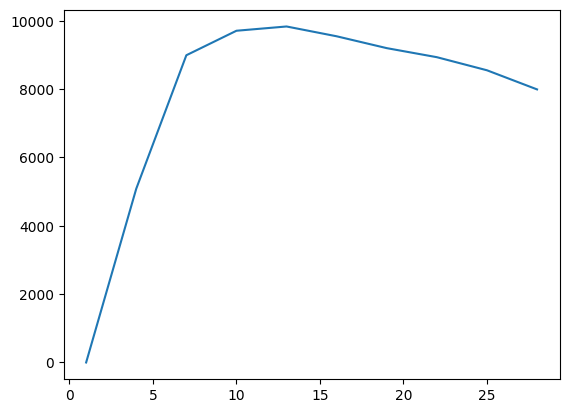

In [ ]:
resets = (3*np.arange(10)+1).astype(int)
T = int(1e6); dist_target = 5; radius_target = 1; D = 1
plt.plot(resets, multi_loop_constant_2D(T, resets, dist_target, radius_target, D))

#### Loop saving position

In [ ]:
#|export
@njit(parallel = True)
def reset_loop_saving_positions_2D(n_agents, T, reset_policy, dist_target, radius_target, D):

    positions = np.zeros((n_agents, T, 2))
    rewards = 0
    
    tau = 0 # time since last reset    
    for n in prange(n_agents):

        env = ResetEnv_2D(dist_target, radius_target, D) 
        
        for t in range(T):
            
            action = 0 if np.random.rand() > reset_policy[tau] else 1
            rew = env.update_pos(action = action)
            
            if rew == 1 or action == 1:
                tau = 0
            else:
                tau += 1            
            rewards += rew
    
            positions[n, t] = env.position
    
    return positions

In [ ]:
# from rl_opts.rl_framework_numba import ResetEnv_2D

In [ ]:
env = ResetEnv_2D(dist_target = 5, radius_target = 1, D = 1)   
reset = 1000
reset_policy = np.zeros(reset)
reset_policy[reset-1] = 1 
# reset_policy[int(reset/2)] = 0.5
dist_target = 2; radius_target = 0.5; D = 0.1
target_position = np.array([dist_target*np.cos(np.pi/4), dist_target*np.sin(np.pi/4)])

In [ ]:
T = 50
positions = reset_loop_saving_positions_2D(n_agents = int(1e6), T = T, reset_policy = reset_policy, 
                                     dist_target = dist_target, radius_target = radius_target, D = D)

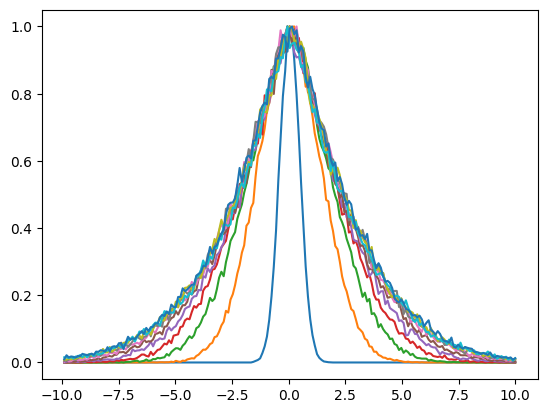

In [ ]:
bins = np.linspace(-dist_target, dist_target, 200)

for t in range(T)[::10]:
    h, _ = np.histogram(pos[pos[:,t,0] != 0,t,0], bins = bins);

    plt.plot(bins[1:], h/h.max())

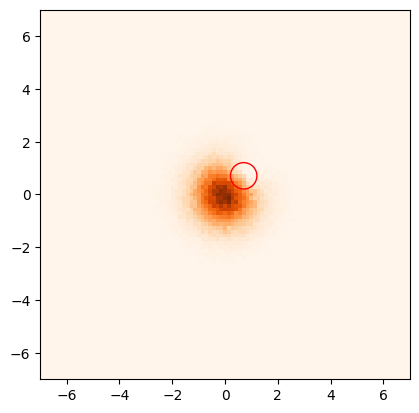

In [ ]:
# import matplotlib.patches as patches
bins = np.linspace(-7, 7, 100)
t = 3
# plt.scatter(target_position[0], target_position[1], s = 10, c = 'r', zorder = 10)
plt.hist2d(pos[pos[:,t,0] != 0,t,0], pos[pos[:,t,0] != 0,t,1], bins = bins, cmap = 'Oranges');

circle = patches.Circle(target_position, radius_target, edgecolor='r', facecolor='none')
plt.gca().add_patch(circle)

# Adjust the aspect ratio
plt.gca().set_aspect('equal', adjustable='box')

#### Animation

In [ ]:
#| export
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.pyplot as plt

def animate_positions_with_target(bins, positions, radius_target, target_position, cmap = 'Oranges'):

    # Create the figure and axis for plotting
    fig, ax = plt.subplots(figsize=(6, 6))
    # Initialize the 2D histogram and circle patch for the target
    hist = ax.hist2d(positions[positions[:,0,0] != 0, 0, 0],
                     positions[positions[:,0,0] != 0, 0, 1], bins=bins, density=True, cmap = cmap)
    circle = patches.Circle(target_position, radius_target, edgecolor='r', facecolor='none')
    ax.add_patch(circle)
    
    # Setting the aspect ratio and limits of the plot
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(np.min(positions[:, :, 0]), np.max(positions[:, :, 0]))
    ax.set_ylim(np.min(positions[:, :, 1]), np.max(positions[:, :, 1]))
    
    # Update function for the animation
    def update(frame):
        ax.clear()
        ax.hist2d(positions[positions[:,frame,0] != 0, frame, 0], 
                  positions[positions[:,frame,0] != 0, frame, 1], bins=bins, density=True, cmap = cmap)
        ax.add_patch(patches.Circle(target_position, radius_target, edgecolor='r', facecolor='none'))
        ax.set_aspect('equal', adjustable='box')
        return ax,
    
    # Create the animation
    ani = FuncAnimation(fig, update, frames=T, interval=100, blit=False)
    fig.close()
    return ani


In [ ]:
bins = np.linspace(-10, 10, 1000)

ani = animation(bins, positions, radius_target, target_position, cmap = 'Greys')
# Display the animation
HTML(ani.to_jshtml())

## Move + Reset Env

### 1D

In [ ]:
#|export
@jitclass
class MoveResetEnv_1D():
    L : float
    step_length : float    
    position : float    
    current_direction : float
    
    def __init__(self,
                 L = 1.3,
                 step_length = 1.0,                    
                ):        
   
        self.L = L
        self.step_length = step_length
        self.position = 0
        self.current_direction = np.sign(np.random.randn())
        
    def init_env(self):
        self.position = 0

    def update_pos(self, change_direction, reset):        
        """
        Updates information of the agent depending on its decision.

        Parameters
        ----------
        change_direction : bool
            Whether the agent decided to turn or not.
        reset: bool
            Whether the agent is reset to its original position
        agent_index : int, optional
            Index of the given agent. The default is 0.
        """     
        
        
        if change_direction:
            self.current_direction = np.sign(np.random.randn())
        
        #Update position
        if not reset:
            self.position += self.current_direction*self.step_length
        else:
            self.position = 0
            return 0 # if we reset we know we did not get the reward

        if self.position >= self.L: 
            self.init_env()
            return 1
        else: 
            return 0            

In [ ]:
env = MoveResetEnv_1D(L = 15, step_length = 1)

pos = []
for time in range(10000):
    pos.append(env.position)
    env.update_pos(False if np.random.rand() > 0.5 else True, 
                   True if time % 2500 == 0 else False)

<matplotlib.lines.Line2D>

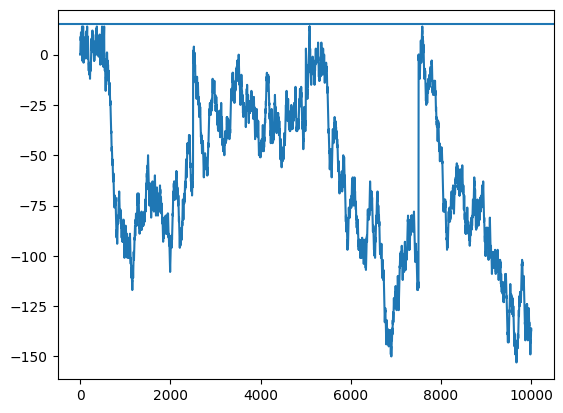

In [ ]:
plt.plot(pos)
plt.axhline(env.L)

#### No-train search loops

In [ ]:
#|export
@njit
def MoveReset_allfixed(T, reset, turn, env):
    
    rewards = 0
    tau_reset = 0 # time since last reset
    tau_turn = 0 # time since last turn
    
    for t in range(T):
        
        if tau_reset == reset:
            rew = env.update_pos(False, # change direction
                                 True # reset
                                )
            tau_reset = 0
            tau_turn = 0 # We reset the turn counter when resetting, investigate if this is what we want!
            
        elif tau_turn == turn:
            rew = env.update_pos(True, # change direction
                                 False # reset
                                )
            tau_turn = 0
        
        else:
            rew = env.update_pos(False, # change direction
                                 False # reset
                                )
            tau_reset += 1
            tau_turn += 1       
        
        rewards += rew
        
    return rewards


@njit(parallel = True)
def multi_loop_MoveReset_allfixed(T, resets, turns, L, step_length):  

    rews = np.zeros((len(resets), len(turns)))

    if len(resets) > len(turns):
        for idxr in prange(len(resets)):
            for idxt in range(len(turns)):                
                env = MoveResetEnv_1D(L, step_length)        
                rews[idxr, idxt] = MoveReset_allfixed(T, resets[idxr], turns[idxt],env)

    else:
        for idxt in prange(len(turns)):
            for idxr in range(len(resets)):                            
                env = MoveResetEnv_1D(L, step_length)        
                rews[idxr, idxt] = MoveReset_allfixed(T, resets[idxr], turns[idxt],env)

    return rews


In [ ]:
env = MoveResetEnv_1D(L = 5, step_length = 1)

T = int(1e7)
reset = 500
turns = np.arange(10, 20)
L = 5.0
step_length = 1.0


env = MoveResetEnv_1D(L = L, step_length = step_length)

#rewards = MoveReset_allfixed(T = T, reset = reset, turn = turns[0], env = env)


rews = multi_loop_MoveReset_allfixed(T = int(1e8), resets = np.array([500]), turns = np.arange(5, 10), L = 16.0, step_length = 1.0)

[<matplotlib.lines.Line2D>]

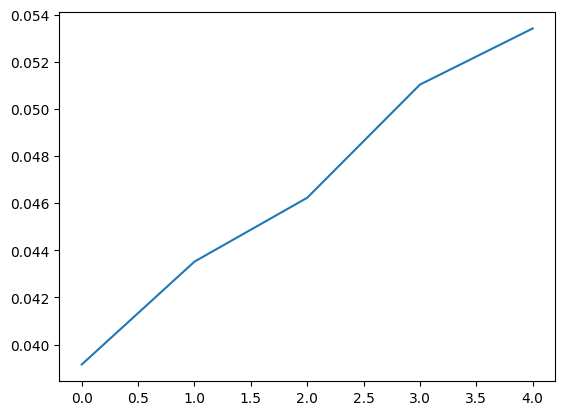

In [ ]:
plt.plot(rews[0]/T)

### 2D

In [ ]:
#|export
@jitclass([("position", float64[:]),
           ("target_position", float64[:,:]),
           ("previous_pos", float64[:])
          ])
class MoveResetEnv_2D():
    agent_step : float    
    dist_target :float
    r: float
    position : np.array    
    target_position : np.array
    previous_pos : np.array
    current_direction : float
    
    def __init__(self,
                 dist_target = 0.2, # Distance from init position and target
                 radius_target = 0.5, # Radius of the target
                 agent_step = 1.0, # Diffusion coefficient of the walker              
                ):   
        
        '''Open question: here we consider no boundaries, to properly replicate 1D. But in the MoveReset environment there will be boundaries?'''
        

        self.agent_step = agent_step
        self.dist_target = dist_target
        self.r = radius_target        
        
        self.target_position = np.array([self.dist_target*np.cos(np.pi/4), self.dist_target*np.sin(np.pi/4)])[np.newaxis, :]       
        
        self.init_env()
        
    def init_env(self):
        self.position = np.array([0.0,0.0])
        self.current_direction = np.random.rand()*2*np.pi
        self.previous_pos = self.position.copy()     
        
        
    
    def update_pos(self, change_direction, reset):        
        """
        Updates information of the agent depending on its decision.

        Parameters
        ----------
        change_direction : bool
            Whether the agent decided to turn or not.
        reset: bool
            Whether the agent is reset to its original position
        """
        
        if reset:
            self.init_env()
            return 0

        else:
            if change_direction:
                self.current_direction = np.random.rand()*2*np.pi

            self.position[0] += self.agent_step*np.cos(self.current_direction)
            self.position[1] += self.agent_step*np.sin(self.current_direction)

            # Checking encounter
            inside_target = np.linalg.norm(self.position-self.target_position) <= self.r
            crossed_target = isBetween_c_Vec_numba(self.previous_pos, self.position, self.target_position, self.r)
                        
            if inside_target or crossed_target:
                self.init_env()
                return 1
            else:                
                self.previous_pos = self.position.copy()
                return 0

In [ ]:
L = 100
env = MoveResetEnv_2D(dist_target = 2)
T = 200
pos = np.zeros((2, T))
time_enc = []
for time in (range(T)):
    pos[:, time] = env.position
    rew = env.update_pos(False if np.random.rand() > 0.5 else True, True if time % 500 == 0 else False)
    if rew == 1:
        time_enc.append(time)

print(len(time_enc))    

1


'\nSee that we are seeing here is the reseting step, because the real step in which we crossed the target is not recorded\nbecause we do a env.init_env() when crossing the target and the one that gets out of the function is init_position\n'

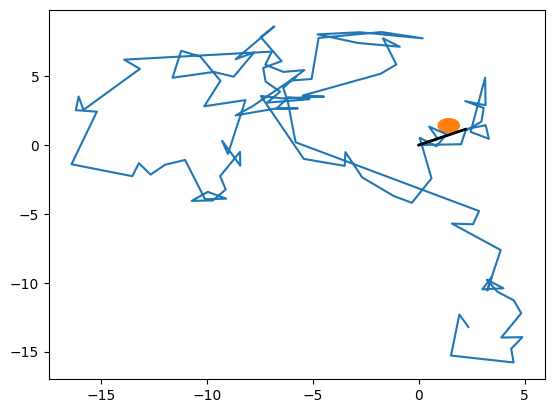

In [ ]:
fig, ax = plt.subplots()
ax.plot(pos[0], pos[1])

target = plt.Circle(env.target_position[0], env.r, color='C1')
ax.add_patch(target)

for t in time_enc:
    plt.plot(pos[0, t:t+2], pos[1, t:t+2], c = 'k', lw = 2)


'''
See that we are seeing here is the reseting step, because the real step in which we crossed the target is not recorded
because we do a env.init_env() when crossing the target and the one that gets out of the function is init_position
'''

#### Multi-target

In [ ]:
#|export
@jitclass([("target_positions", float64[:,:]),
           ("position", float64[:]),
           ("previous_pos", float64[:]),
           ("init_position", float64[:])
          ])
class MoveResetEnv_multiTarget_2D():
    # inputs
    Nt : int
    L : float
    r : float
    agent_step : float
    target_positions : np.ndarray 
    init_position : np.array
    # others
    current_direction : float
    position : np.array
    previous_pos : np.array
    
    
    def __init__(self,
                 Nt = 10,
                 L = 1.3,
                 r = 1.5,
                 agent_step = 1.0,
                 init_position = np.array([0.0,0.0])
                ):
        
        print('If you want to consider cases with l_c, use MoveResetEnv_withlc_2D')
                    
        """Class defining the foraging environment. It includes the methods needed to place several agents to the world.
        
        Parameters
        ----------
        Nt: int 
            Number of targets.
        L: int
            Size of the (squared) world.
        r: int 
            Radius with center the target position. It defines the area in which agent detects the target.
        lc: np.array
            Cutoff length. Displacement away from target (to implement revisitable targets by displacing agent away from the visited target).
            See lc_distribution for details.
        agent_step: int, optional 
            Displacement of one step. The default is 1.
        num_agents: int, optional 
            Number of agents that forage at the same time. The default is 1.
        destructive: bool, optional
            True if targets are destructive. The default is False.
        lc_distribution: str
            Defines the type of distributions from which lc are sampled. We consider:
                - 'constant': current lc is always lc[0]
                - 'power_law': current lc is sample from power law with exponent = lc[0]
                - 'pareto': current lc is sampled from pareto with exponent = lc[0] and x_min = lc[1]
                - 'arbitrary': current lc is sampled from lc[0] with probabilities given by lc[1]
        init_positions: np.array
            Initial position where agents will be reset. Must be of shape (num_agents, 2).
        """
        self.Nt = Nt
        self.L = L
        self.r = r
        self.agent_step = agent_step 
                    
        # Define the initial position where the agent will be reset each time
        self.init_position = init_position

        self.init_env()
        
    def init_env(self):
        """
        Environment initialization.
        """
        self.target_positions = np.random.rand(self.Nt, 2)*self.L        
        
        
        #set positions and directions of the agents
        self.current_direction = np.random.rand()*2*np.pi
        self.position = self.init_position.copy()
        self.previous_pos = self.position.copy()    

    def update_pos(self, change_direction, reset):        
        """
        Updates information of the agent depending on its decision.

        Parameters
        ----------
        change_direction : bool
            Whether the agent decided to turn or not.
        reset: bool
            Whether the agent is reset to its original position
        """
        
        # Save previous position to check if crossing happened
        self.previous_pos = self.position.copy()
        
        if change_direction:
            self.current_direction = np.random.rand()*2*np.pi
        
        #Update position
        if not reset:
            self.position[0] += self.agent_step*np.cos(self.current_direction)
            self.position[1] += self.agent_step*np.sin(self.current_direction)
        else:
            self.position = self.init_position
        
       
    def check_encounter(self):
        """
        Checks whether the agent found a target, and updates the information accordingly.

        Parameters
        ----------
        agent_index : int, optional

        Returns
        -------
        True if the agent found a target.

        """       
        encounters = isBetween_c_Vec_numba(self.previous_pos, self.position, self.target_positions, self.r)
        
        if sum(encounters) > 0: 
            self.position = self.init_position
            return 1                               
        else: 
            return 0   
        
    def check_bc(self):
        """
        Updates position coordinates of agent agent_index to fulfill periodic boundary conditions.

        """
        self.position = (self.position)%self.L
    

In [ ]:
L = 100
env = MoveResetEnv_2D(L = L, Nt = 100, init_position=np.array([L/2, L/2]))
T = 200
pos = np.zeros((2, T))
target = []
for time in (range(T)):
    pos[:, time] = env.position[0]
    env.update_pos(False if np.random.rand() > 0.5 else True, True if time % 500 == 0 else False)
    if env.check_encounter() == 1: target.append(time)
    #env.check_encounter()
    env.check_bc()
    

If you want to consider cases with l_c, use MoveResetEnv_withlc_2D


<matplotlib.lines.Line2D>

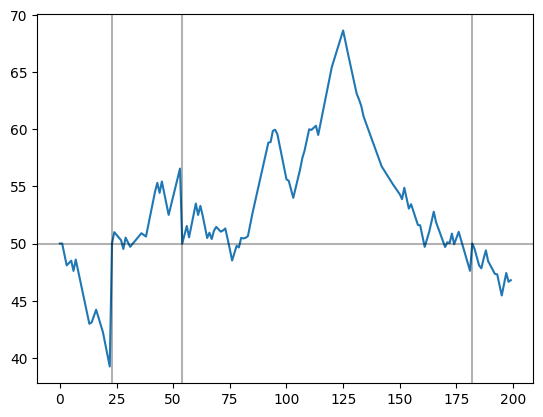

In [ ]:
plt.plot(pos[0])
for t in target: plt.axvline(t+1, c = 'k', alpha = 0.3)
plt.axhline(50, c = 'k', alpha = 0.3)

#### With `l_c`

In [ ]:
#|export
@jitclass([("target_positions", float64[:,:]) ,
           ("current_rewards", float64[:]) ,
           ("kicked", float64[:]) ,
           ("current_directions", float64[:]) ,
           ("positions", float64[:,:]),
           ("previous_pos", float64[:,:]),
           ("lc", float64[:,:]),
           ("mask", bool_[:]),
           ("first_encounter", float64[:,:]),
           ("init_positions", float64[:,:])
          ])
class MoveResetEnv_withlc_2D():
    # inputs
    Nt : int
    L : float
    r : float
    lc : np.array
    agent_step : float
    num_agents : int
    destructive_targets : bool
    target_positions : np.ndarray    
    lc_distribution : str
    init_positions : np.array
    # others
    current_rewards : np.array
    kicked : np.array
    current_directions : np.array
    positions : np.array
    previous_pos : np.array
    mask : np.array
    first_encounter : np.array
    
    
    def __init__(self,
                 Nt = 10,
                 L = 1.3,
                 r = 1.5,
                 lc = np.array([[1.0],[1]]),
                 agent_step = 1.0,
                 num_agents = 1,
                 destructive_targets = False,
                 lc_distribution = 'constant',
                 init_positions = np.array([[0.0,0.0]])
                ):
        
        """Class defining the foraging environment. It includes the methods needed to place several agents to the world.
        
        Parameters
        ----------
        Nt: int 
            Number of targets.
        L: int
            Size of the (squared) world.
        r: int 
            Radius with center the target position. It defines the area in which agent detects the target.
        lc: np.array
            Cutoff length. Displacement away from target (to implement revisitable targets by displacing agent away from the visited target).
            See lc_distribution for details.
        agent_step: int, optional 
            Displacement of one step. The default is 1.
        num_agents: int, optional 
            Number of agents that forage at the same time. The default is 1.
        destructive: bool, optional
            True if targets are destructive. The default is False.
        lc_distribution: str
            Defines the type of distributions from which lc are sampled. We consider:
                - 'constant': current lc is always lc[0]
                - 'power_law': current lc is sample from power law with exponent = lc[0]
                - 'pareto': current lc is sampled from pareto with exponent = lc[0] and x_min = lc[1]
                - 'arbitrary': current lc is sampled from lc[0] with probabilities given by lc[1]
        init_positions: np.array
            Initial position where agents will be reset. Must be of shape (num_agents, 2).
        """
        self.Nt = Nt
        self.L = L
        self.r = r
        self.lc = lc
        self.agent_step = agent_step 
        self.num_agents = num_agents
        self.destructive_targets = destructive_targets
        self.lc_distribution = lc_distribution
        
        # Define the initial position where the agent will be reset each time
        self.init_positions = init_positions

        self.init_env()
        
    def init_env(self):
        """
        Environment initialization.
        """
        self.target_positions = np.random.rand(self.Nt, 2)*self.L
        
        #store who is/was rewarded
        self.current_rewards = np.zeros(self.num_agents)
        
        #signal whether agent has been kicked
        self.kicked = np.zeros(self.num_agents)
        
        #set positions and directions of the agents
        self.current_directions = np.random.rand(self.num_agents)*2*np.pi
        self.positions = self.init_positions.copy()
        self.previous_pos = self.positions.copy()    

        

    def update_pos(self, change_direction, reset):        
        """
        Updates information of the agent depending on its decision.

        Parameters
        ----------
        change_direction : bool
            Whether the agent decided to turn or not.
        reset: bool
            Whether the agent is reset to its original position
        agent_index : int, optional
            Index of the given agent. The default is 0.
        """
        
        # This is needed because we work with single agent and want to keep the code as general as possible in other parts
        agent_index = 0
        # Save previous position to check if crossing happened
        self.previous_pos[agent_index] = self.positions[agent_index].copy()
        
        if change_direction:
            self.current_directions[agent_index] = random.uniform(0,1)*2*math.pi
        
        #Update position
        if not reset:
            self.positions[agent_index][0] += self.agent_step*np.cos(self.current_directions[agent_index])
            self.positions[agent_index][1] += self.agent_step*np.sin(self.current_directions[agent_index])
        else:
            self.positions[agent_index] = self.init_positions[agent_index]
        
       
    def check_encounter(self):
        """
        Checks whether the agent found a target, and updates the information accordingly.

        Parameters
        ----------
        agent_index : int, optional

        Returns
        -------
        True if the agent found a target.

        """       
        agent_index=0
        encounters = isBetween_c_Vec_numba(self.previous_pos[agent_index], self.positions[agent_index], self.target_positions, self.r)
        
        if sum(encounters) > 0: 
            
            #if there is more than 1 encounter, pick the closest to the agent.
            if sum(encounters) == 1:
                first_encounter = np.argwhere(encounters == True).flatten()
            else:
                # compute the distance from the previous position to each target            
                distance_previous_pos = np.sqrt((self.previous_pos[agent_index][0]- self.target_positions[:, 0])**2 + (self.previous_pos[agent_index][1] - self.target_positions[:, 1])**2)            
                
                # checking which encountered point is closer to previous position
                min_distance_masked = np.argmin(distance_previous_pos[encounters])
                first_encounter = np.argwhere(encounters == True)[min_distance_masked].flatten()
                
            if self.destructive_targets:
                self.target_positions[first_encounter] = np.random.rand(2)*self.L
            else:
                #----KICK----
                # If there was encounter, we reset direction and change position of particle to (pos target + lc)
                kick_direction = np.random.uniform(low = 0, high = 2*np.pi)
                for idx_first in first_encounter: # This is super weird!
                    if self.lc_distribution == 'power_law':
                        # when we have the power law, the first value of lc is considered to be the exponent.
                        # The following samples from a power law x^{-1-alpha} where alpha = self.lc.flatten()[0]                        
                        current_lc = (1-random.uniform(0,1))**(-1/self.lc.flatten()[0])
                    elif self.lc_distribution == 'pareto':
                        # Sampling from Pareto. Here alpha = self.lc.flatten()[0] and x_minim = self.lc.flatten()[0]
                        current_lc = pareto_sample(self.lc[0,0], self.lc[1,0])[0]
                    elif self.lc_distribution == 'constant':
                        # if lc has a single element, take that one as lc, if not sample
                        current_lc = self.lc.flatten()[0] 
                    elif self.lc_distribution == 'arbitrary':
                        # In this case lc[0] is support of distribution and lc[1] is probability
                        current_lc = rand_choice_nb(arr = self.lc[0], prob = self.lc[1])
                    elif self.lc_distribution == 'none':
                        # This case considers that there is no lc. If we hit the target, we go directly to origin position
                        self.positions[agent_index] = self.init_positions[agent_index]
                        self.kicked[agent_index] = 1
                        return 1
                    
                    self.positions[agent_index][0] = self.target_positions[idx_first, 0] + current_lc*np.cos(kick_direction)
                    self.positions[agent_index][1] = self.target_positions[idx_first, 1] + current_lc*np.sin(kick_direction)
                self.kicked[agent_index] = 1
                #------------
                
            #...and we add the information that this agent got to the target
            self.current_rewards[agent_index] = 1              
            return 1
        
        else: 
            self.kicked[agent_index] = 0
            self.current_rewards[agent_index] = 0
            return 0   
        
    def check_bc(self):
        """
        Updates position coordinates of agent agent_index to fulfill periodic boundary conditions.

        """
        agent_index=0
        self.positions[agent_index] = (self.positions[agent_index])%self.L
    

In [ ]:
L = 100
env = MoveResetEnv_2D(L = L, Nt = 100, init_positions=np.array([[L/2, L/2]]), lc_distribution = 'none')
T = 200
pos = np.zeros((2, T))
target = []
for time in tqdm(range(T)):
    pos[:, time] = env.positions[0]
    env.update_pos(False if np.random.rand() > 0.5 else True, True if time % 500 == 0 else False)
    if env.check_encounter() == 1: target.append(time)
    #env.check_encounter()
    env.check_bc()
    

  0%|          | 0/200 [00:00<?, ?it/s]

<matplotlib.lines.Line2D>

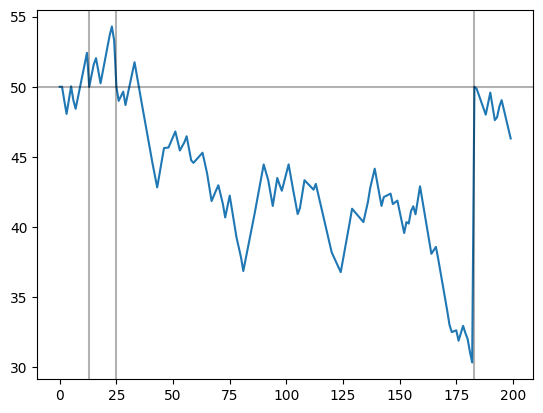

In [ ]:
plt.plot(pos[0])
for t in target: plt.axvline(t+1, c = 'k', alpha = 0.3)
plt.axhline(50, c = 'k', alpha = 0.3)

#### No-train search loops

##### Base MoveRest_2D

In [ ]:
#| export
@njit
def MoveReset2D_allfixed(T, reset, turn, env):
    
    rewards = 0
    tau_reset = 0 # time since last reset
    tau_turn = 0 # time since last turn
    
    for t in range(T):
        
        if tau_reset == reset:
            rew = env.update_pos(True, # change direction
                                 True # reset
                                )
            tau_reset = 0
            tau_turn = 0 # We reset the turn counter when resetting, as we are also changing turning when resetting
            
        elif tau_turn == turn:
            rew = env.update_pos(True, # change direction
                                 False # reset
                                )
            tau_turn = 0
        
        else:
            rew = env.update_pos(False, # change direction
                                 False # reset
                                )
            tau_reset += 1
            tau_turn += 1  

        if rew == 1:
            tau_reset = 0
            tau_turn = 0
        
        rewards += rew
        
    return rewards


@njit(parallel = True)
def multi_loop_MoveReset2D_allfixed(T, resets, turns, dist_target, radius_target, agent_step):  

    rews = np.zeros((len(resets), len(turns)))

    if len(resets) > len(turns):
        for idxr in prange(len(resets)):
            for idxt in range(len(turns)):                
                env = MoveResetEnv_2D(dist_target, radius_target, agent_step)        
                rews[idxr, idxt] = MoveReset2D_allfixed(T, resets[idxr], turns[idxt],env)

    else:
        for idxt in prange(len(turns)):
            for idxr in range(len(resets)):           
                env = MoveResetEnv_2D(dist_target, radius_target, agent_step)          
                rews[idxr, idxt] = MoveReset2D_allfixed(T, resets[idxr], turns[idxt],env)

    return rews

In [ ]:
# from rl_opts.rl_framework_numba import MoveResetEnv_2D

In [ ]:
T = 1000; reset = 5; turn = 2;
env = MoveResetEnv_2D()
rews = MoveReset2D_allfixed(T, reset, turn, env)

In [ ]:
rews = multi_loop_MoveReset2D_allfixed(T = int(1e4), resets = np.array([500]), turns = np.arange(2, 10),  
                                       dist_target = 5, radius_target = 1.5, agent_step = 1.3)

[<matplotlib.lines.Line2D>]

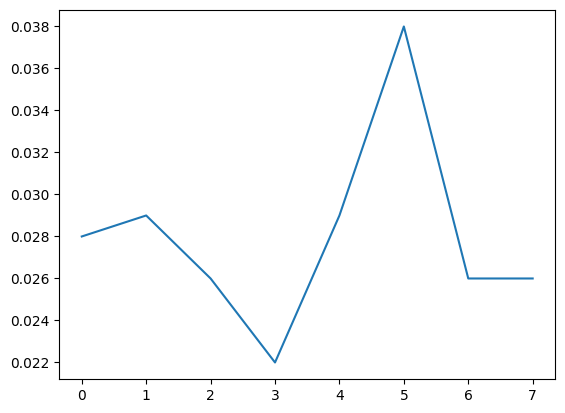

In [ ]:
plt.plot(rews[0]/T)

##### Multi target 

In [ ]:
#|export
@njit
def MoveReset2D_multitarget_allfixed(T, reset, turn, env):
    
    rewards = 0
    tau_reset = 0 # time since last reset
    tau_turn = 0 # time since last turn
    
    for t in range(T):
        
        if tau_reset == reset:
            env.update_pos(False, # change direction
                           True # reset
                          )
            rew = env.check_encounter()
            
            tau_reset = 0
            tau_turn = 0 # We reset the turn counter when resetting, investigate if this is what we want!
            
        elif tau_turn == turn:
            env.update_pos(True, # change direction
                           False # reset
                          )
            rew = env.check_encounter()
            
            tau_turn = 0
        
        else:
            rew = env.update_pos(False, # change direction
                                 False # reset
                                )
            rew = env.check_encounter()
            
            tau_reset += 1
            tau_turn += 1       
        
        rewards += rew
        
    return rewards

@njit(parallel = True)
def multi_loop_MoveReset2D_multitarget_allfixed(T, resets, turns, L, Nt, r, step_length, init_position):  

    rews = np.zeros((len(resets), len(turns)))
    
    if len(resets) > len(turns):
        for idxr in prange(len(resets)):
            for idxt in range(len(turns)):                
                env = MoveResetEnv_2D(Nt, L, r, step_length, init_position)     
                rews[idxr, idxt] = MoveReset2D_allfixed(T, resets[idxr], turns[idxt],env)

    else:
        for idxt in prange(len(turns)):
            for idxr in range(len(resets)): 
                env = MoveResetEnv_2D(Nt, L, r, step_length, init_position)
                rews[idxr, idxt] = MoveReset2D_allfixed(T, resets[idxr], turns[idxt],env)

    return rews


In [ ]:
T = 1000; reset = 5; turn = 2;
env = MoveResetEnv_2D()
rews = MoveReset2D_allfixed(T, reset, turn, env)

In [ ]:
rews = multi_loop_MoveReset2D_multitarget_allfixed(T = int(1e7), resets = np.array([500]), turns = np.arange(2, 10), L = L, 
                                       Nt = Nt, r = 1, init_position = np.array([L/2, L/2]),step_length = step_length)

[<matplotlib.lines.Line2D>]

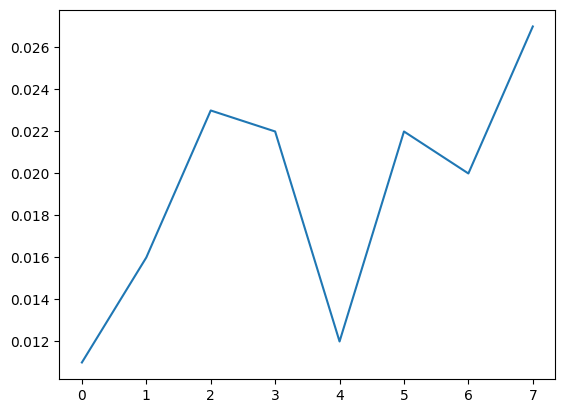

In [ ]:
plt.plot(rews[0]/T)

# Projective Simulation agent

## BASE agent

In [ ]:
# |export
@jitclass([("num_percepts_list", int64[:]),           
           ("initial_prob_distr", float64[:,:]),           
           ("fixed_policy", float64[:,:]) ,
           ("h_matrix", float64[:,:]) ,
           ("g_matrix", float64[:,:]) ,
           ("h_0", float64[:,:]),
          ])
class PSAgent():
    num_actions : int
    gamma_damping : float
    eta_glow_damping : float
    policy_type : str
    beta_softmax : float
    num_percepts : int
    num_percepts_list : np.array
    initial_prob_distr : np.array
    fixed_policy : np.array    
    h_matrix : np.array
    g_matrix : np.array
    h_0 : np.array
    
    def __init__(self, num_actions, 
                 num_percepts_list, 
                 gamma_damping=0.0, 
                 eta_glow_damping=0.0, 
                 policy_type='standard', 
                 beta_softmax=3, 
                 initial_prob_distr = np.array([[],[]]), 
                 fixed_policy=np.array([[],[]])):
        """
        Base class of a Reinforcement Learning agent based on Projective Simulation,
        with two-layered network. This class has been adapted from https://github.com/qic-ibk/projectivesimulation

        Parameters
        ----------
        num_actions : int >=1
            Number of actions.
        num_percepts_list : ARRAY of integers >=1, not nested
            Cardinality of each category/feature of percept space.
        gamma_damping : float (between 0 and 1), optional
            Forgetting/damping of h-values at the end of each interaction. The default is 0.0.
        eta_glow_damping : float (between 0 and 1), optional
            Controls the damping of glow; setting this to 1 effectively switches off glow. The default is 0.0.
        policy_type : string, 'standard' or 'softmax', optional
            Toggles the rule used to compute probabilities from h-values. See probability_distr. The default is 'standard'.
        beta_softmax : float >=0, optional
            Probabilities are proportional to exp(beta*h_value). If policy_type != 'softmax', then this is irrelevant. The default is 3.
        initial_prob_distr : ARRAY
            In case the user wants to change the initialization policy for the agent. This list contains, per percept, a list with the values of the initial h values for each action. The default is None.
        fixed_policy : ARRAY
            In case the user wants to fix a policy for the agent. This list contains, per percept, a list with the values of the probabilities for each action. 
            Example: Percept 0: fixed_policy[0] = [p(a0), p(a1), p(a2)] = [0.2, 0.3, 0.5], where a0, a1 and a2 are the three possible actions. The default is None.

        """
        
        self.num_actions = num_actions
        self.num_percepts_list = num_percepts_list
        self.gamma_damping = gamma_damping
        self.eta_glow_damping = eta_glow_damping
        self.policy_type = policy_type
        self.beta_softmax = beta_softmax
        self.initial_prob_distr = initial_prob_distr
        self.fixed_policy = fixed_policy
        
        self.num_percepts = int(np.prod(self.num_percepts_list)) # total number of possible percepts
        
        self.g_matrix = np.zeros((self.num_actions, self.num_percepts), dtype=np.float64) #glow matrix, for processing delayed rewards
        
        # initialize h matrix with different values
        if len(self.initial_prob_distr[0]) > 0:
            self.h_0 = self.initial_prob_distr
            self.h_matrix = self.h_0.copy()
        else: 
            self.h_matrix = np.ones((self.num_actions, self.num_percepts), dtype=np.float64) #Note: the first index specifies the action, the second index specifies the percept.
            
    def percept_preprocess(self, observation):
        """
        Takes a multi-feature percept and reduces it to a single integer index.

        Parameters
        ----------
        observation : ARRAY of integers >=0, of the same length as self.num_percepts_list
            List that describes the observation. Each entry is the value that each feature takes in the observation.
            observation[i] < num_percepts_list[i] (strictly)

        Returns
        -------
        percept : int
            Percept index that corresponds to the input observation.

        """
        
        percept = 0
        for which_feature in range(len(observation)):
            percept += int(observation[which_feature] * np.prod(self.num_percepts_list[:which_feature]))
        return percept
    
    def deliberate(self, observation):
        """
        Given an observation , this method chooses the next action and records that choice in the g_matrix.

        Parameters
        ----------
        observation : list
            List that describes the observation, as specified in percept_preprocess.

        Returns
        -------
        action : int
            Index of the chosen action.

        """
        percept = self.percept_preprocess(observation) 
        action = rand_choice_nb(arr = np.arange(self.num_actions), prob = self.probability_distr(percept))
        self.g_matrix = (1 - self.eta_glow_damping) * self.g_matrix
        self.g_matrix[action, percept] += 1 #record latest decision in g_matrix
        return action
    
    def probability_distr(self, percept):
        """
        Given a percept index, this method returns a probability distribution over actions.

        Parameters
        ----------
        percept : int
            Index of the given percept.

        Returns
        -------
        probability_distr : np.array, length = num_actions
            Probability for each action (normalized to unit sum), computed according to policy_type.

        """
        
        if self.policy_type == 'standard':
            h_vector = self.h_matrix[:, percept]
            probability_distr = h_vector / np.sum(h_vector)
        elif self.policy_type == 'softmax':
            h_vector = self.beta_softmax * self.h_matrix[:, percept]
            h_vector_mod = h_vector - np.max(h_vector)
            probability_distr = np.exp(h_vector_mod) / np.sum(np.exp(h_vector_mod))
        return probability_distr
    
    def learn(self, reward):
        """
        Given a reward, this method updates the h matrix.

        Parameters
        ----------
        reward : float
            Value of the obtained reward.
        """
        if len(self.initial_prob_distr[0]) > 0:
            self.h_matrix =  self.h_matrix - self.gamma_damping * (self.h_matrix - self.h_0) + reward * self.g_matrix
        else:
            self.h_matrix =  self.h_matrix - self.gamma_damping * (self.h_matrix - 1.) + reward * self.g_matrix
            
    def reset_g(self):
        """
        Resets the g_matrix.
        """
        self.g_matrix = np.zeros((self.num_actions, self.num_percepts), dtype=np.float64)
        
    def deliberate_fixed_policy(self, observation):
        """
        Given an observation , this method chooses the next action according to the fixed policy specified as attribute of the class.

        Parameters
        ----------
        observation : list
            List that describes the observation, as specified in percept_preprocess.

        Returns
        -------
        action : int
            Index of the chosen action.

        """
        percept = self.percept_preprocess(observation) 
        if len(self.fixed_policy[0]) > 0:
            action = rand_choice_nb(arr = np.arange(self.num_actions), prob = self.fixed_policy[percept])
        else:
            print('No fixed policy was given to the agent. The action will be selected randomly.')
            action = np.random.choice(self.num_actions)
    
        self.g_matrix = (1 - self.eta_glow_damping) * self.g_matrix
        self.g_matrix[action, percept] += 1 #record latest decision in g_matrix
    
        return action
    

In [ ]:
ps = PSAgent(num_actions = 10, num_percepts_list = np.array([15]))
ps.percept_preprocess([0]*ps.num_percepts_list)
ps.probability_distr(0)
observation = [0]*ps.num_percepts_list[0]
ps.deliberate(np.array(observation))
ps.learn(1)
ps.reset_g()
ps.deliberate_fixed_policy(np.array(observation))

No fixed policy was given to the agent. The action will be selected randomly.


7

## Forager

In [ ]:
# |export
@jitclass([("num_percepts_list", int64[:]),           
           ("initial_prob_distr", float64[:,:]),           
           ("fixed_policy", float64[:,:]) ,
           ("h_matrix", float64[:,:]) ,
           ("g_matrix", float64[:,:]) ,
           ("h_0", float64[:,:]),
           ])
class Forager():
    num_actions : int
    gamma_damping : float
    eta_glow_damping : float
    policy_type : str
    beta_softmax : float
    num_percepts : int
    agent_state : int
    num_percepts_list : np.array
    initial_prob_distr : np.array
    fixed_policy : np.array    
    h_matrix : np.array
    g_matrix : np.array
    h_0 : np.array
    
    def __init__(self, num_actions, 
                 state_space, 
                 gamma_damping=0.0, 
                 eta_glow_damping=0.0, 
                 policy_type='standard', 
                 beta_softmax=3, 
                 initial_prob_distr = np.array([[],[]]), 
                 fixed_policy=np.array([[],[]])):
        """
        Same as PSAGENT but: num_percepts_list -> state_space
        
        state_space : list
            List where each entry is the state space of each perceptual feature.
            E.g. [state space of step counter, state space of density of successful neighbours].
        """
        
        self.agent_state = 0
        
        self.num_actions = num_actions
        self.num_percepts_list = np.array([len(i) for i in state_space], dtype = np.int64) # change w.r.t PSAGENT
        self.gamma_damping = gamma_damping
        self.eta_glow_damping = eta_glow_damping
        self.policy_type = policy_type
        self.beta_softmax = beta_softmax
        self.initial_prob_distr = initial_prob_distr
        self.fixed_policy = fixed_policy
        
        self.num_percepts = int(np.prod(self.num_percepts_list)) # total number of possible percepts
        
        self.init_matrices()
        
    def init_matrices(self):

        self.g_matrix = np.zeros((self.num_actions, self.num_percepts)) #glow matrix, for processing delayed rewards

        # initialize h matrix with different values
        if len(self.initial_prob_distr[0]) > 0:          
            self.h_0 = self.initial_prob_distr
            self.h_matrix = self.h_0.copy()
        else: 
            self.h_matrix = np.ones((self.num_actions, self.num_percepts), dtype=np.float64) #Note: the first index specifies the action, the second index specifies the percept.
            
    def percept_preprocess(self, observation):
        """
        Takes a multi-feature percept and reduces it to a single integer index.

        Parameters
        ----------
        observation : ARRAY of integers >=0, of the same length as self.num_percepts_list
            List that describes the observation. Each entry is the value that each feature takes in the observation.
            observation[i] < num_percepts_list[i] (strictly)

        Returns
        -------
        percept : int
            Percept index that corresponds to the input observation.

        """
        
        percept = 0
        for which_feature in range(len(observation)):
            percept += int(observation[which_feature] * np.prod(self.num_percepts_list[:which_feature]))
        return percept
    
    def deliberate(self, observation):
        """
        Given an observation , this method chooses the next action and records that choice in the g_matrix.

        Parameters
        ----------
        observation : list
            List that describes the observation, as specified in percept_preprocess.
        
        Returns
        -------
        action : int
            Index of the chosen action.

        """
        percept = self.percept_preprocess(observation) 
        action = rand_choice_nb(arr = np.arange(self.num_actions), prob = self.probability_distr(percept))
        self.g_matrix = (1 - self.eta_glow_damping) * self.g_matrix
        self.g_matrix[action, percept] += 1 #record latest decision in g_matrix
        return action
    
    def probability_distr(self, percept):
        """
        Given a percept index, this method returns a probability distribution over actions.

        Parameters
        ----------
        percept : int
            Index of the given percept.

        Returns
        -------
        probability_distr : np.array, length = num_actions
            Probability for each action (normalized to unit sum), computed according to policy_type.

        """
        
        if self.policy_type == 'standard':
            h_vector = self.h_matrix[:, percept]
            probability_distr = h_vector / np.sum(h_vector)
        elif self.policy_type == 'softmax':
            h_vector = self.beta_softmax * self.h_matrix[:, percept]
            h_vector_mod = h_vector - np.max(h_vector)
            probability_distr = np.exp(h_vector_mod) / np.sum(np.exp(h_vector_mod))
        return probability_distr
    
    def learn(self, reward):
        """
        Given a reward, this method updates the h matrix.

        Parameters
        ----------
        reward : float
            Value of the obtained reward.
        """
        if len(self.initial_prob_distr[0]) > 0:
            self.h_matrix =  self.h_matrix - self.gamma_damping * (self.h_matrix - self.h_0) + reward * self.g_matrix
        else:
            self.h_matrix =  self.h_matrix - self.gamma_damping * (self.h_matrix - 1.) + reward * self.g_matrix
            
    def reset_g(self):
        """
        Resets the g_matrix.
        """
        self.g_matrix = np.zeros((self.num_actions, self.num_percepts), dtype=np.float64)
        
    def deliberate_fixed_policy(self, observation):
        """
        Given an observation , this method chooses the next action according to the fixed policy specified as attribute of the class.

        Parameters
        ----------
        observation : list
            List that describes the observation, as specified in percept_preprocess.

        Returns
        -------
        action : int
            Index of the chosen action.

        """
        percept = self.percept_preprocess(observation) 
        if len(self.fixed_policy[0]) > 0:
            action = rand_choice_nb(arr = np.arange(self.num_actions), prob = self.fixed_policy[percept])
        else:
            print('No fixed policy was given to the agent. The action will be selected randomly.')
            action = np.random.choice(self.num_actions)
    
        self.g_matrix = (1 - self.eta_glow_damping) * self.g_matrix
        self.g_matrix[action, percept] += 1 #record latest decision in g_matrix
    
        return action
    
    def act(self, action):
        """
        Agent performs the given action.

        Parameters
        ----------
        action : int (0, 1)
            1 if it changes direction, 0 otherwise
        """
        
        # If the agent changes direction   
        if action == 1:
            self.agent_state = 0
        else:
            self.agent_state += 1  
            
    
    def get_state(self):  
        ''' simplified to case of single forager. Returns list because is what deliberate needs'''
        return np.array([self.agent_state])

In [ ]:
agent = Forager(num_actions = 2, state_space = np.array([np.arange(100)]))
agent.percept_preprocess([0]*agent.num_percepts_list)
agent.probability_distr(0)
observation = [0]*agent.num_percepts_list[0]
agent.deliberate(np.array(observation))
agent.learn(1)
agent.reset_g()
agent.deliberate_fixed_policy(np.array(observation))
agent.act(0)
agent.get_state()

No fixed policy was given to the agent. The action will be selected randomly.


array([1])

## Forager with efficient H update

We use the formula $H_{t+i} = (1-\gamma)^i H_t + \gamma H_0 \sum_{j=1}^i(1-\gamma)^{j-1}$

In [ ]:
# |export
@jitclass([("num_percepts_list", int64[:]),           
           ("initial_prob_distr", float64[:,:]),           
           ("fixed_policy", float64[:,:]) ,
           ("h_matrix", float64[:,:]) ,
           ("g_matrix", float64[:,:]) ,
           ("h_0", float64[:,:]),
           ("prefactor_1", float64[:]),
           ("prefactor_2", float64[:])
          ])
class Forager_efficient_H():
    num_actions : int
    gamma_damping : float
    eta_glow_damping : float
    policy_type : str
    beta_softmax : float
    num_percepts : int
    agent_state : int
    max_no_update : int
    counter_upd : int
    num_percepts_list : np.array
    initial_prob_distr : np.array
    fixed_policy : np.array    
    h_matrix : np.array
    g_matrix : np.array
    h_0 : np.array
    prefactor_1: np.array
    prefactor_2: np.array
    
    def __init__(self, num_actions, 
                 state_space, 
                 gamma_damping=0.0, 
                 eta_glow_damping=0.0, 
                 policy_type='standard', 
                 beta_softmax=3, 
                 initial_prob_distr = np.array([[],[]]), 
                 fixed_policy=np.array([[],[]]),
                 max_no_update = int(1e4)
                ):
        """
        Same as PSAGENT but: num_percepts_list -> state_space
        
        state_space : list
            List where each entry is the state space of each perceptual feature.
            E.g. [state space of step counter, state space of density of successful neighbours].
        """
        
        self.agent_state = 0
        
        self.num_actions = num_actions
        self.num_percepts_list = np.array([len(i) for i in state_space], dtype = np.int64) # change w.r.t PSAGENT
        self.gamma_damping = gamma_damping
        self.eta_glow_damping = eta_glow_damping
        self.policy_type = policy_type
        self.beta_softmax = beta_softmax
        self.initial_prob_distr = initial_prob_distr
        self.fixed_policy = fixed_policy
        
        self.num_percepts = int(np.prod(self.num_percepts_list)) # total number of possible percepts
        
        self.init_matrices()
        
        self.max_no_update = max_no_update      
        self.counter_upd = 0
        self.prefactor_1 = (1-self.gamma_damping)**(np.arange(1, self.max_no_update+1)) 
        self.prefactor_2 = np.zeros(self.max_no_update)
        for i in range(self.max_no_update):
            self.prefactor_2[i] = self.gamma_damping*np.sum((1-self.gamma_damping)**np.arange(i+1))
        
    def init_matrices(self):

        self.g_matrix = np.zeros((self.num_actions, self.num_percepts)) #glow matrix, for processing delayed rewards

        # initialize h matrix with different values
        if len(self.initial_prob_distr[0]) > 0:          
            self.h_0 = self.initial_prob_distr
            self.h_matrix = self.h_0.copy()
        else: 
            self.h_matrix = np.ones((self.num_actions, self.num_percepts), dtype=np.float64) #Note: the first index specifies the action, the second index specifies the percept.
            
    def _learn_post_reward(self, reward):
        if self.counter_upd == 0:
            print('Counter for h_matrix is zero, check that your are properly updating it!')
        if len(self.initial_prob_distr[0]) > 0:
            self.h_matrix = self.prefactor_1[self.counter_upd-1] * self.h_matrix + self.prefactor_2[self.counter_upd-1] * self.h_0 + reward * self.g_matrix
        else:
            self.h_matrix = self.prefactor_1[self.counter_upd-1] * self.h_matrix + self.prefactor_2[self.counter_upd-1] + reward * self.g_matrix
        self.counter_upd = 0
        
    def _hmat_upd_single_percept(self, t, percept):
        if len(self.initial_prob_distr[0]) > 0:
            return self.prefactor_1[t-1] * self.h_matrix[:, percept] + self.prefactor_2[t-1] * self.h_0[:, percept]
        else:
            return self.prefactor_1[t-1] * self.h_matrix[:, percept] + self.prefactor_2[t-1] 
            
            
    def percept_preprocess(self, observation):
        """
        Takes a multi-feature percept and reduces it to a single integer index.

        Parameters
        ----------
        observation : ARRAY of integers >=0, of the same length as self.num_percepts_list
            List that describes the observation. Each entry is the value that each feature takes in the observation.
            observation[i] < num_percepts_list[i] (strictly)

        Returns
        -------
        percept : int
            Percept index that corresponds to the input observation.

        """
        
        percept = 0
        for which_feature in range(len(observation)):
            percept += int(observation[which_feature] * np.prod(self.num_percepts_list[:which_feature]))
        return percept
    
    def deliberate(self, observation):
        """
        Given an observation , this method chooses the next action and records that choice in the g_matrix.

        Parameters
        ----------
        observation : list
            List that describes the observation, as specified in percept_preprocess.

        Returns
        -------
        action : int
            Index of the chosen action.

        """
        percept = self.percept_preprocess(observation) 
        
        # Probabilities must be of update h_matrix. We feed the prob distr the update h_matrix
        # for the percept, but don't update the h_matrix
        if self.counter_upd == 0:
            current_h_mat = self.h_matrix[:, percept]
        else:
            current_h_mat = self._hmat_upd_single_percept(self.counter_upd, percept)
        probs = self.probability_distr(percept, h_matrix = current_h_mat)
        
        action = rand_choice_nb(arr = np.arange(self.num_actions), prob = probs)
        self.g_matrix = (1 - self.eta_glow_damping) * self.g_matrix
        self.g_matrix[action, percept] += 1 #record latest decision in g_matrix
        return action
    
    def probability_distr(self, percept, h_matrix = None):
        """
        UPDATE (added the optional input)
         
        Given a percept index, this method returns a probability distribution over actions.

        Parameters
        ----------
        percept : int
            Index of the given percept.

        Returns
        -------
        probability_distr : np.array, length = num_actions
            Probability for each action (normalized to unit sum), computed according to policy_type.

        """
        
        if self.policy_type == 'standard':
            h_vector = self.h_matrix[:, percept] if h_matrix is None else h_matrix
            probability_distr = h_vector / np.sum(h_vector)
        elif self.policy_type == 'softmax':
            h_vector = self.beta_softmax * self.h_matrix[:, percept] if h_matrix is None else h_matrix
            h_vector_mod = h_vector - np.max(h_vector)
            probability_distr = np.exp(h_vector_mod) / np.sum(np.exp(h_vector_mod))
        return probability_distr
    
    def learn(self, reward):
        """
        Given a reward, this method updates the h matrix.

        Parameters
        ----------
        reward : float
            Value of the obtained reward.
        """
        if len(self.initial_prob_distr[0]) > 0:
            self.h_matrix =  self.h_matrix - self.gamma_damping * (self.h_matrix - self.h_0) + reward * self.g_matrix
        else:
            self.h_matrix =  self.h_matrix - self.gamma_damping * (self.h_matrix - 1.) + reward * self.g_matrix
            
    def reset_g(self):
        """
        Resets the g_matrix.
        """
        self.g_matrix = np.zeros((self.num_actions, self.num_percepts), dtype=np.float64)
        
    def deliberate_fixed_policy(self, observation):
        """
        Given an observation , this method chooses the next action according to the fixed policy specified as attribute of the class.

        Parameters
        ----------
        observation : list
            List that describes the observation, as specified in percept_preprocess.

        Returns
        -------
        action : int
            Index of the chosen action.

        """
        percept = self.percept_preprocess(observation) 
        if len(self.fixed_policy[0]) > 0:
            action = rand_choice_nb(arr = np.arange(self.num_actions), prob = self.fixed_policy[percept])
        else:
            print('No fixed policy was given to the agent. The action will be selected randomly.')
            action = np.random.choice(self.num_actions)
    
        self.g_matrix = (1 - self.eta_glow_damping) * self.g_matrix
        self.g_matrix[action, percept] += 1 #record latest decision in g_matrix
    
        return action
    
    def act(self, action):
        """
        Agent performs the given action.

        Parameters
        ----------
        action : int (0, 1)
            1 if it changes direction, 0 otherwise
        """
        
        # If the agent changes direction   
        if action == 1:
            self.agent_state = 0
        else:
            self.agent_state += 1  
            
    
    def get_state(self):  
        ''' simplified to case of single forager. Returns list because is what deliberate needs'''
        return np.array([self.agent_state])

**Testing**

In [ ]:
def test_train_loop_Heff(efficient, agent, episodes):
    
    for i in range(episodes):
        
        if efficient:
            agent.counter_upd += 1
        
        state = np.array([i])
        
        if i % 2 == 0:
            action = 0
        else: 1
        
        # here is where glow matrix updates:
        agent.g_matrix = (1 - agent.eta_glow_damping) * agent.g_matrix
        agent.g_matrix[action, i] += 1 #record latest decision in g_matrix
        
        if i == 2 or i == 6:
            reward = 1
        else: reward = 0
        
        if efficient:
            if reward == 1:
                agent._learn_post_reward(reward)
        else:
            agent.learn(reward)
            
    return agent

**Value testing**

In [ ]:
eps = 100
agent_noopt = Forager(num_actions = 2,
                    state_space = np.array([np.arange(eps)]))
trained_noopt = test_train_loop_Heff(efficient = False, agent = agent_noopt, episodes = eps)
trained_noopt.h_matrix

agent_opt = Forager_efficient_H(num_actions = 2,
                              state_space = np.array([np.arange(eps)]))
trained = test_train_loop_Heff(efficient=True, agent = agent_opt, episodes = eps)

f'comparison old and efficient: {(trained.h_matrix-trained_noopt.h_matrix).sum()} ||||| IF value != 0, something is wrong!!!'

'comparison old and efficient: 0.0 ||||| IF value != 0, something is wrong!!!'

## Forager with efficient G and H update
> This is full efficient, both w.r.t. G and H

In [ ]:
# |export
@jitclass([("size_state_space", int64[:]),           
           ("initial_prob_distr", float64[:,:]),           
           ("fixed_policy", float64[:,:]) ,
           ("h_matrix", float64[:,:]) ,
           ("g_matrix", float64[:,:]) ,
           ("h_0", float64[:,:]),
           ("prefactor_1", float64[:]),
           ("prefactor_2", float64[:]),
           ("last_upd_G", float64[:,:])
          ])
class Forager_efficient():
    num_actions : int
    gamma_damping : float
    eta_glow_damping : float
    policy_type : str
    beta_softmax : float
    num_percepts : int
    agent_state : int
    size_state_space : np.array
    initial_prob_distr : np.array
    fixed_policy : np.array    
    h_matrix : np.array
    g_matrix : np.array
    h_0 : np.array
    g_update : str
    # Efficient H update
    prefactor_1: np.array
    prefactor_2: np.array
    max_no_H_update : int
    N_upd_H : int
    # Efficient G update
    last_upd_G: np.array
    N_upd_G: int
    
    def __init__(self, num_actions, 
                 size_state_space, 
                 gamma_damping=0.0, 
                 eta_glow_damping=0.0, 
                 policy_type='standard', 
                 beta_softmax=3, 
                 initial_prob_distr = np.array([[],[]]), 
                 fixed_policy=np.array([[],[]]),
                 max_no_H_update = int(1e4),
                 g_update = 's', # if to do: s (sum) -> g_mat += 1 or r (reset) -> gmat = 1 when updating gmat
                ):
        """
        Updated version of the FORAGER class, with an efficient update both for the H-matrix
        and the G-matrix.
        
        size_state_space : np.array
            num of percepts for each feature
        """
        
        self.agent_state = 0
        
        self.num_actions = num_actions
        self.size_state_space = size_state_space
        self.num_percepts = int(np.prod(self.size_state_space)) # total number of possible percepts
        
        self.gamma_damping = gamma_damping
        self.eta_glow_damping = eta_glow_damping
        self.policy_type = policy_type
        self.beta_softmax = beta_softmax
        self.initial_prob_distr = initial_prob_distr
        self.fixed_policy = fixed_policy    
        self.g_update = g_update
        
        self.init_matrices()
        
        # For H update
        self.max_no_H_update = max_no_H_update      
        self.N_upd_H = 0
        self.prefactor_1 = (1-self.gamma_damping)**(np.arange(1,self.max_no_H_update+1)) 
        self.prefactor_2 = np.zeros(self.max_no_H_update)
        for i in range(max_no_H_update):
            self.prefactor_2[i] = self.gamma_damping*np.sum((1-self.gamma_damping)**np.arange(i+1))
            
        # For G update
        self.last_upd_G = np.zeros((self.num_actions, self.num_percepts))
        self.N_upd_G = 0
                              
        
    def init_matrices(self):

        self.g_matrix = np.zeros((self.num_actions, self.num_percepts)) #glow matrix, for processing delayed rewards

        # initialize h matrix with different values
        if len(self.initial_prob_distr[0]) > 0:          
            self.h_0 = self.initial_prob_distr
            self.h_matrix = self.h_0.copy()
        else: 
            self.h_matrix = np.ones((self.num_actions, self.num_percepts), dtype=np.float64) #Note: the first index specifies the action, the second index specifies the percept.
            
    def _learn_post_reward(self, reward):
        '''Given a reward, updates the whole H-matrix taking into account that we did not have updates
        for the last N_upd_H steps.'''
        # Update the full G matrix
        self._G_upd_full()
        
        if self.N_upd_H == 0:
            print('Counter for h_matrix is zero, check that your are properly updating it!')
        if len(self.initial_prob_distr[0]) > 0:
            self.h_matrix = self.prefactor_1[self.N_upd_H-1] * self.h_matrix + self.prefactor_2[self.N_upd_H-1] * self.h_0 + reward * self.g_matrix
        else:
            self.h_matrix = self.prefactor_1[self.N_upd_H-1] * self.h_matrix + self.prefactor_2[self.N_upd_H-1] + reward * self.g_matrix
        self.N_upd_H = 0
        
    def _H_upd_single_percept(self, t, percept):
        '''Given a percept and the time t passed since the last H-matrix update,
        returns the corresponding --updated-- column of the H-matrix for all actions.
        This updated is local and does no affect the H-matrix.'''
        if len(self.initial_prob_distr[0]) > 0:
            return self.prefactor_1[t-1] * self.h_matrix[:, percept] + self.prefactor_2[t-1] * self.h_0[:, percept]
        else:
            return self.prefactor_1[t-1] * self.h_matrix[:, percept] + self.prefactor_2[t-1] 
        
    def _G_upd_single_percept(self, percept, action):
        '''Given a percept-action tuple, updates that element of the G-matrix. Updates the last_upd_G
        to keep track of when was the matrix updated.'''
        
        if self.g_update == 's': # For the current (a,s) tuple, we damp and sum one
            self.g_matrix[action, percept] = (1 - self.eta_glow_damping)**(self.N_upd_G - self.last_upd_G[action, percept])*self.g_matrix[action, percept] + 1
        elif self.g_update == 'r':
            self.g_matrix[action, percept] = 1
        
        # Then update the last_upd matrix
        self.last_upd_G[action, percept] = self.N_upd_G
        
    def _G_upd_full(self):
        '''Given the current number of steps without an update, updates the whole G-matrix.
        Then, resets all counters.'''
        self.g_matrix = (1 - self.eta_glow_damping)**(self.N_upd_G - self.last_upd_G) * self.g_matrix
        self.N_upd_G = 0
        self.last_upd_G = np.zeros((self.num_actions, self.num_percepts))
            
            
    def percept_preprocess(self, observation):
        """
        Takes a multi-feature percept and reduces it to a single integer index.

        Parameters
        ----------
        observation : ARRAY of integers >=0, of the same length as self.num_percepts_list
            List that describes the observation. Each entry is the value that each feature takes in the observation.
            observation[i] < num_percepts_list[i] (strictly)

        Returns
        -------
        percept : int
            Percept index that corresponds to the input observation.

        """
        
        percept = 0
        for idx_obs, obs_feature in enumerate(observation):
            percept += int(obs_feature * np.prod(self.size_state_space[:idx_obs]))  
        return percept
    
    def deliberate(self, observation):
        """
        Given an observation , this method chooses the next action and records that choice in the g_matrix.

        Parameters
        ----------
        observation : list
            List that describes the observation, as specified in percept_preprocess.
        action : optional, bool
            Mostly for debugging, we can input the action and no deliberation takes place, but g_matrix is updated

        Returns
        -------
        action : int
            Index of the chosen action.

        """
        percept = self.percept_preprocess(observation) 
        
        
        # Probabilities must be of update h_matrix. We feed the prob distr the update h_matrix
        # for the percept, but don't update the h_matrix
        if self.N_upd_H == 0:
            current_h_mat = self.h_matrix[:, percept]
        else:
            current_h_mat = self._H_upd_single_percept(self.N_upd_H, percept)
        probs = self.probability_distr(percept, h_matrix = current_h_mat)        
        action = rand_choice_nb(arr = np.arange(self.num_actions), prob = probs)
        
        # Update the G matrix for current (s,a) tuple
        self._G_upd_single_percept(percept, action)
        
        return action
    
    def probability_distr(self, percept, h_matrix = None):
        """
        UPDATE (added the optional input)
         
        Given a percept index, this method returns a probability distribution over actions.

        Parameters
        ----------
        percept : int
            Index of the given percept.

        Returns
        -------
        probability_distr : np.array, length = num_actions
            Probability for each action (normalized to unit sum), computed according to policy_type.

        """
        
        if self.policy_type == 'standard':
            h_vector = self.h_matrix[:, percept] if h_matrix is None else h_matrix
            probability_distr = h_vector / np.sum(h_vector)
        elif self.policy_type == 'softmax':
            h_vector = self.beta_softmax * self.h_matrix[:, percept] if h_matrix is None else h_matrix
            h_vector_mod = h_vector - np.max(h_vector)
            probability_distr = np.exp(h_vector_mod) / np.sum(np.exp(h_vector_mod))
        return probability_distr
    
    def learn(self, reward):
        """
        Given a reward, this method updates the h matrix.

        Parameters
        ----------
        reward : float
            Value of the obtained reward.
        """
        if len(self.initial_prob_distr[0]) > 0:
            self.h_matrix =  self.h_matrix - self.gamma_damping * (self.h_matrix - self.h_0) + reward * self.g_matrix
        else:
            self.h_matrix =  self.h_matrix - self.gamma_damping * (self.h_matrix - 1.) + reward * self.g_matrix
            
    def reset_g(self):
        """
        Resets the g_matrix.
        """
        self.g_matrix = np.zeros((self.num_actions, self.num_percepts), dtype=np.float64)
        
    def deliberate_fixed_policy(self, observation):
        """
        Given an observation , this method chooses the next action according to the fixed policy specified as attribute of the class.

        Parameters
        ----------
        observation : list
            List that describes the observation, as specified in percept_preprocess.

        Returns
        -------
        action : int
            Index of the chosen action.

        """
        percept = self.percept_preprocess(observation) 
        if len(self.fixed_policy[0]) > 0:
            action = rand_choice_nb(arr = np.arange(self.num_actions), prob = self.fixed_policy[percept])
        else:
            print('No fixed policy was given to the agent. The action will be selected randomly.')
            action = np.random.choice(self.num_actions)
    
        self.g_matrix = (1 - self.eta_glow_damping) * self.g_matrix
        self.g_matrix[action, percept] += 1 #record latest decision in g_matrix
    
        return action
    
    def act(self, action):
        """
        Agent performs the given action.

        Parameters
        ----------
        action : int (0, 1)
            1 if it changes direction, 0 otherwise
        """
        
        # If the agent changes direction   
        if action == 1:
            self.agent_state = 0
        else:
            self.agent_state += 1  
            
    
    def get_state(self):  
        ''' simplified to case of single forager. Returns list because is what deliberate needs'''
        return np.array([self.agent_state])

##### Value testing
> We replicate a training with the original agent and the efficient one to check that the resulting h-matrix is equal. Note that because the deliberate is random, the value $!=1$ in  h_matrix may be in different rows (actions) for the two agents (but always on the same column, i.e. state).

In [ ]:
# from rl_opts.rl_framework_numba import Forager_efficient, Forager

In [ ]:
gamma, eta = 0.5, 0.5
steps = 5
size_state_space = 10

ag_og = Forager(num_actions = 2, state_space = np.array([np.arange(size_state_space)]),
                gamma_damping=gamma, 
                eta_glow_damping=eta
               )

ag_ef = Forager_efficient(num_actions = 2, size_state_space = np.array([size_state_space]),
                              eta_glow_damping = eta, gamma_damping = gamma)

for i in range(steps-1):
    ag_og.learn(0)
ag_og.deliberate(np.array([i]))
ag_og.learn(1)
for i in range(steps-1):
    ag_og.learn(0)

ag_ef.N_upd_H = steps-1
ag_ef.N_upd_G = steps-1
ag_ef._learn_post_reward(0)

ag_ef.N_upd_H += 1
ag_ef.N_upd_G += 1
ag_ef.deliberate(np.array([i]))
ag_ef._learn_post_reward(1)

ag_ef.N_upd_H = steps-1
ag_ef.N_upd_G = steps-1
ag_ef._learn_post_reward(0)

ag_og.h_matrix, ag_ef.h_matrix

(array([[1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
         1.    , 1.    ],
        [1.    , 1.    , 1.    , 1.0625, 1.    , 1.    , 1.    , 1.    ,
         1.    , 1.    ]]),
 array([[1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
         1.    , 1.    ],
        [1.    , 1.    , 1.    , 1.0625, 1.    , 1.    , 1.    , 1.    ,
         1.    , 1.    ]]))

**Runtime testing**

In [ ]:
eps = int(1e4); eta = 0.1
agent_noopt = Forager(num_actions = 2,
                      state_space = np.array([np.arange(eps)]), eta_glow_damping = eta)
agent_opt = Forager_efficient(num_actions = 2,
                              state_space = np.array([np.arange(eps)]), eta_glow_damping = eta)

In [ ]:
%timeit test_G_train_loop(efficient=True, agent = agent_opt, episodes = eps)

22.7 ms ± 78.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit test_G_train_loop(efficient=False, agent = agent_noopt, episodes = eps)

367 ms ± 7.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Forager with action dependent glow and damping

In [ ]:
# |export
@jitclass([("size_state_space", int64[:]),           
           ("initial_prob_distr", float64[:,:]),           
           ("fixed_policy", float64[:,:]) ,
           ("h_matrix", float64[:,:]) ,
           ("g_matrix", float64[:,:]) ,
           ("h_0", float64[:,:]),
           ("prefactor_1", float64[:,:]),
           ("prefactor_2", float64[:,:]),
           ("last_upd_G", float64[:,:]),
           ('gamma_damping', float64[:]),
           ('eta_glow_damping', float64[:])
          ])
class Forager_multi_param():
    num_actions : int
    gamma_damping : np.array
    eta_glow_damping : np.array
    policy_type : str
    beta_softmax : float
    num_percepts : int
    agent_state : int
    size_state_space : np.array
    initial_prob_distr : np.array
    fixed_policy : np.array    
    h_matrix : np.array
    g_matrix : np.array
    h_0 : np.array
    # Efficient H update
    prefactor_1: np.array
    prefactor_2: np.array
    max_no_H_update : int
    N_upd_H : int
    # Efficient G update
    last_upd_G: np.array
    N_upd_G: int
    
    def __init__(self, num_actions = 2, 
                 size_state_space = np.array([1000]), 
                 gamma_damping=np.array([0.5, 1.0]), 
                 eta_glow_damping=np.array([0.5, 1.0]), 
                 policy_type='standard', 
                 beta_softmax=3, 
                 initial_prob_distr = np.array([[],[]]), 
                 fixed_policy=np.array([[],[]]),
                 max_no_H_update = int(1e4)
                ):
        """
        Same as Forager_efficient but with different glows and damping factors for each action
        
        size_state_space : np.array
            num of percepts for each feature
        """
        
        self.agent_state = 0
        
        self.num_actions = num_actions
        self.size_state_space = size_state_space
        self.num_percepts = int(np.prod(self.size_state_space)) # total number of possible percepts
        
        self.gamma_damping = gamma_damping
        self.eta_glow_damping = eta_glow_damping
        self.policy_type = policy_type
        self.beta_softmax = beta_softmax
        self.initial_prob_distr = initial_prob_distr
        self.fixed_policy = fixed_policy       
        
        self.init_matrices()
        
        # For H update
        self.max_no_H_update = max_no_H_update      
        self.N_upd_H = 0

        self.prefactor_1 = (1 - self.gamma_damping[:, np.newaxis]) ** np.arange(1, self.max_no_H_update + 1)
        # self.prefactor_2 = self.gamma_damping[:, np.newaxis] * np.cumsum((1 - self.gamma_damping[:, np.newaxis]) ** np.arange(self.max_no_H_update), axis=1)
        
        self.prefactor_2 = np.zeros((self.gamma_damping.size, self.max_no_H_update))
        
        # Calculate the cumulative sum manually for each damping factor
        for i in range(self.gamma_damping.size):
            cumulative_sum = 0
            for j in range(self.max_no_H_update):
                cumulative_sum += (1 - self.gamma_damping[i]) ** j
                self.prefactor_2[i, j] = self.gamma_damping[i] * cumulative_sum

    
        # For G update
        self.last_upd_G = np.zeros((self.num_actions, self.num_percepts))
        self.N_upd_G = 0        

                     
        
    def init_matrices(self):

        self.g_matrix = np.zeros((self.num_actions, self.num_percepts)) #glow matrix, for processing delayed rewards

        # initialize h matrix with different values
        if len(self.initial_prob_distr[0]) > 0:          
            self.h_0 = self.initial_prob_distr
            self.h_matrix = self.h_0.copy()
        else: 
            self.h_matrix = np.ones((self.num_actions, self.num_percepts), dtype=np.float64) #Note: the first index specifies the action, the second index specifies the percept.
            
    def _learn_post_reward(self, reward):
        '''Given a reward, updates the whole H-matrix taking into account that we did not have updates
        for the last N_upd_H steps.'''
        # Update the full G matrix
        self._G_upd_full()
        
        if self.N_upd_H == 0:
            print('Counter for h_matrix is zero, check that your are properly updating it!')
        if len(self.initial_prob_distr[0]) > 0:
            self.h_matrix = self.prefactor_1[:, self.N_upd_H-1][:, np.newaxis] * self.h_matrix 
            self.h_matrix += self.prefactor_2[:, self.N_upd_H-1][:, np.newaxis] * self.h_0 + reward * self.g_matrix
        else:
            self.h_matrix = self.prefactor_1[:, self.N_upd_H-1][:, np.newaxis] * self.h_matrix 
            self.h_matrix += self.prefactor_2[:, self.N_upd_H-1][:, np.newaxis] + reward * self.g_matrix
        self.N_upd_H = 0
        
    def _H_upd_single_percept(self, t, percept):
        '''Given a percept and the time t passed since the last H-matrix update,
        returns the corresponding --updated-- column of the H-matrix for all actions.
        This updated is local and does no affect the H-matrix.'''
        if len(self.initial_prob_distr[0]) > 0:
            return self.prefactor_1[:, t-1] * self.h_matrix[:, percept] + self.prefactor_2[:, t-1] * self.h_0[:, percept]
        else:
            return self.prefactor_1[:, t-1] * self.h_matrix[:, percept] + self.prefactor_2[:, t-1] 
        
    def _G_upd_single_percept(self, percept, action):
        '''Given a percept-action tuple, updates that element of the G-matrix. Updates the last_upd_G
        to keep track of when was the matrix updated.'''
        # For the current (a,s) tuple, we damp and sum one
        self.g_matrix[action, percept] = (1 - self.eta_glow_damping[action])**(self.N_upd_G - self.last_upd_G[action, percept])*self.g_matrix[action, percept] + 1
        # Then update the last_upd matrix
        self.last_upd_G[action, percept] = self.N_upd_G
        
    def _G_upd_full(self):
        '''Given the current number of steps without an update, updates the whole G-matrix.
        Then, resets all counters.'''
        self.g_matrix = (1 - self.eta_glow_damping[:, np.newaxis])**(self.N_upd_G - self.last_upd_G) * self.g_matrix
        self.N_upd_G = 0
        self.last_upd_G = np.zeros((self.num_actions, self.num_percepts))
            
       

     
    def percept_preprocess(self, observation):
        """
        Takes a multi-feature percept and reduces it to a single integer index.

        Parameters
        ----------
        observation : ARRAY of integers >=0, of the same length as self.num_percepts_list
            List that describes the observation. Each entry is the value that each feature takes in the observation.
            observation[i] < num_percepts_list[i] (strictly)

        Returns
        -------
        percept : int
            Percept index that corresponds to the input observation.

        """
        
        percept = 0
        for idx_obs, obs_feature in enumerate(observation):
            percept += int(obs_feature * np.prod(self.size_state_space[:idx_obs]))  
        return percept
    
    def deliberate(self, observation):
        """
        Given an observation , this method chooses the next action and records that choice in the g_matrix.

        Parameters
        ----------
        observation : list
            List that describes the observation, as specified in percept_preprocess.
        action : optional, bool
            Mostly for debugging, we can input the action and no deliberation takes place, but g_matrix is updated

        Returns
        -------
        action : int
            Index of the chosen action.

        """
        percept = self.percept_preprocess(observation) 
        
        
        # Probabilities must be of update h_matrix. We feed the prob distr the update h_matrix
        # for the percept, but don't update the h_matrix
        if self.N_upd_H == 0:
            current_h_mat = self.h_matrix[:, percept]
        else:
            current_h_mat = self._H_upd_single_percept(self.N_upd_H, percept)
        probs = self.probability_distr(percept, h_matrix = current_h_mat)        
        action = rand_choice_nb(arr = np.arange(self.num_actions), prob = probs)
        
        # Update the G matrix for current (s,a) tuple
        self._G_upd_single_percept(percept, action)
        
        return action
    
    def probability_distr(self, percept, h_matrix = None):
        """
        UPDATE (added the optional input)
         
        Given a percept index, this method returns a probability distribution over actions.

        Parameters
        ----------
        percept : int
            Index of the given percept.

        Returns
        -------
        probability_distr : np.array, length = num_actions
            Probability for each action (normalized to unit sum), computed according to policy_type.

        """
        
        if self.policy_type == 'standard':
            h_vector = self.h_matrix[:, percept] if h_matrix is None else h_matrix
            probability_distr = h_vector / np.sum(h_vector)
        elif self.policy_type == 'softmax':
            h_vector = self.beta_softmax * self.h_matrix[:, percept] if h_matrix is None else h_matrix
            h_vector_mod = h_vector - np.max(h_vector)
            probability_distr = np.exp(h_vector_mod) / np.sum(np.exp(h_vector_mod))
        return probability_distr
    
            
    def reset_g(self):
        """
        Resets the g_matrix.
        """
        self.g_matrix = np.zeros((self.num_actions, self.num_percepts), dtype=np.float64)
        
    def deliberate_fixed_policy(self, observation):
        """
        Given an observation , this method chooses the next action according to the fixed policy specified as attribute of the class.

        Parameters
        ----------
        observation : list
            List that describes the observation, as specified in percept_preprocess.

        Returns
        -------
        action : int
            Index of the chosen action.

        """
        percept = self.percept_preprocess(observation) 
        if len(self.fixed_policy[0]) > 0:
            action = rand_choice_nb(arr = np.arange(self.num_actions), prob = self.fixed_policy[percept])
        else:
            print('No fixed policy was given to the agent. The action will be selected randomly.')
            action = np.random.choice(self.num_actions)
    
        self.g_matrix = (1 - self.eta_glow_damping) * self.g_matrix
        self.g_matrix[action, percept] += 1 #record latest decision in g_matrix
    
        return action
    
    def act(self, action):
        """
        Agent performs the given action.

        Parameters
        ----------
        action : int (0, 1)
            1 if it changes direction, 0 otherwise
        """
        
        # If the agent changes direction   
        if action == 1:
            self.agent_state = 0
        else:
            self.agent_state += 1  
            
    
    def get_state(self):  
        ''' simplified to case of single forager. Returns list because is what deliberate needs'''
        return np.array([self.agent_state])

##### Test prefactor calculation

In [ ]:
eps = int(1e4); 
etas = np.array([0.99,0.001])
gammas = np.array([0.001, 0.001])

agent = Forager_multi_param(num_actions = 2,
                                 size_state_space = np.array([10]), 
                                 eta_glow_damping = etas, gamma_damping = gammas)
                                 
agent_og = Forager_efficient(num_actions = 2, size_state_space = np.array([10]),
                              eta_glow_damping = etas[0], gamma_damping = gammas[0])

assert (agent.prefactor_1[0,:] == agent_og.prefactor_1).all()
assert (agent.prefactor_2[0,:] == agent_og.prefactor_2).all()

##### Test update of h_matrix

In [ ]:
# from rl_opts.rl_framework_numba import rand_choice_nb

In [ ]:
etas = np.array([0.001]*2)
gammas = np.array([0.001]*2)

agent = Forager_multi_param(num_actions = 2,
                                 size_state_space = np.array([10]), 
                                 eta_glow_damping = etas, gamma_damping = gammas)
                                 
agent_og = Forager_efficient(num_actions = 2, size_state_space = np.array([10]),
                              eta_glow_damping = etas[0], gamma_damping = gammas[0])


h_mat = np.zeros((2, agent.size_state_space[0]))

h_mat[0,:] = 1


# h_mat[0,:] = np.random.randint(2, size = agent.size_state_space[0])
# h_mat[1,:] = np.abs(h_mat[0,:]-1)


In [ ]:
agent.h_matrix = h_mat.copy()
agent_og.h_matrix = h_mat.copy()



acs = []
for a in [agent, agent_og]:
    

    a.N_upd_H = 0
    a.N_upd_G = 0
    ac = []
    for i in range(5):
    
        a.N_upd_H += 1
        a.N_upd_G += 1
    
        action = a.deliberate(np.array([i]))
        ac.append(action)
    
        if i == 2 or i == 6:
            reward = 1
        else: 
            reward = 0
            
        if reward == 1:
            a._learn_post_reward(reward)
            
    a._G_upd_full()
    acs.append(ac)

if acs[0] == acs[1]:
    assert np.sum(agent_og.h_matrix - agent.h_matrix) < 1e-10
else:
    print('actions didnt match :( this may be because of luck')

##### Test different gammas

In [ ]:
etas = np.array([0.1]*2)
gammas = np.array([0.1, 0.001])

agent = Forager_multi_param(num_actions = 2,
                                 size_state_space = np.array([10]), 
                                 eta_glow_damping = etas, gamma_damping = gammas)

agent.h_matrix *= 5

agent.N_upd_H = 10
agent.N_upd_G = 10
agent._learn_post_reward(0)

agent.h_matrix

array([[2.39471376, 2.39471376, 2.39471376, 2.39471376, 2.39471376,
        2.39471376, 2.39471376, 2.39471376, 2.39471376, 2.39471376],
       [4.96017952, 4.96017952, 4.96017952, 4.96017952, 4.96017952,
        4.96017952, 4.96017952, 4.96017952, 4.96017952, 4.96017952]])

# Launch multi agent learning

## For TargetEnv

In [ ]:
#| export                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
@njit
def train_loop(episodes, time_ep, agent, env):    
    
    save_rewards = np.zeros((episodes, time_ep))
    
    for ep in range(episodes):
        # print(f'starting episode {ep} for agent {n_agent}')
        #initialize environment and agent's counter and g matrix
        env.init_env()
        agent.agent_state = 0
        agent.reset_g()

        for t in range(time_ep):

            #step to set counter to its min value n=1
            if t == 0 or env.kicked[0]:
                #do one step with random direction (no learning in this step)
                env.update_pos(1)
                #check boundary conditions
                env.check_bc()
                #reset counter
                agent.agent_state = 0
                #set kicked value to false again
                env.kicked[0] = 0
                reward = 0

            else:
                #get perception
                state = agent.get_state()
                #decide
                action = agent.deliberate(state)
                #act (update counter)
                agent.act(action)

                #update positions
                env.update_pos(action)
                #check if target was found + kick if it is
                reward = env.check_encounter()

                #check boundary conditions
                env.check_bc()
                #learn

                agent.learn(reward)                
                    
            save_rewards[ep, t] = reward
      
    
    return save_rewards, agent.h_matrix

In [ ]:
#| export                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
@njit
def train_loop_h_efficient(episodes, time_ep, agent, env, h_mat_allT = False):  

    if h_mat_allT: policy_t = np.zeros((episodes, agent.h_matrix.shape[-1]))
    save_rewards = np.zeros((episodes, time_ep))
    
    for ep in range(episodes):
        # print(f'starting episode {ep} for agent {n_agent}')
        #initialize environment and agent's counter and g matrix
        env.init_env()
        agent.agent_state = 0
        agent.reset_g()

        for t in range(time_ep):
            agent.counter_upd += 1
            
            #step to set counter to its min value n=1
            if t == 0 or env.kicked[0]:
                #do one step with random direction (no learning in this step)
                env.update_pos(1)
                #check boundary conditions
                env.check_bc()
                #reset counter
                agent.agent_state = 0
                #set kicked value to false again
                env.kicked[0] = 0
                reward = 0

            else:
                #get perception
                state = agent.get_state()
                #decide
                action = agent.deliberate(state)
                #act (update counter)
                agent.act(action)

                #update positions
                env.update_pos(action)
                #check if target was found + kick if it is
                reward = env.check_encounter()

                #check boundary conditions
                env.check_bc()
                #learn
                if reward == 1 or agent.counter_upd > agent.max_no_update:
                    agent._learn_post_reward(reward)
                    
            # Saving
            save_rewards[ep, t] = reward
            if h_mat_allT: policy_t[ep] = agent.h_matrix[0,:] / agent.h_matrix.sum(0)
      
    return (save_rewards, policy_t) if h_mat_allT else (save_rewards, agent.h_matrix)

In [ ]:
#| export                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
@njit
def train_loop_full_efficient(episodes, time_ep, agent, env, h_mat_allT = False):  

    if h_mat_allT: policy_t = np.zeros((episodes, agent.h_matrix.shape[-1]))
    save_rewards = np.zeros((episodes, time_ep))
    
    for ep in range(episodes):
        # print(f'starting episode {ep} for agent {n_agent}')
        #initialize environment and agent's counter and g matrix
        env.init_env()
        agent.agent_state = 0
        agent.reset_g()

        for t in range(time_ep):
            agent.N_upd_H += 1
            agent.N_upd_G += 1
            
            #step to set counter to its min value n=1
            if t == 0 or env.kicked[0]:
                #do one step with random direction (no learning in this step)
                env.update_pos(1)
                #check boundary conditions
                env.check_bc()
                #reset counter
                agent.agent_state = 0
                #set kicked value to false again
                env.kicked[0] = 0
                reward = 0

            else:
                #get perception
                state = agent.get_state()
                #decide
                action = agent.deliberate(state)
                #act (update counter)
                agent.act(action)

                #update positions
                env.update_pos(action)
                #check if target was found + kick if it is
                reward = env.check_encounter()

                #check boundary conditions
                env.check_bc()
                #learn
                if reward == 1:
                    agent._learn_post_reward(reward)

            if agent.N_upd_H == agent.max_no_H_update-1:
                agent._learn_post_reward(reward)
            
                

            # Saving
            save_rewards[ep, t] = reward
            
        if h_mat_allT: policy_t[ep] = agent.h_matrix[0,:] / agent.h_matrix.sum(0)
      
    return (save_rewards, policy_t) if h_mat_allT else (save_rewards, agent.h_matrix)

In [ ]:
#| export
@njit(parallel = True)
def run_agents(episodes, time_ep, N_agents,
               # Environment props
               Nt = 100,
               L = 100,
               r = 0.5,
               lc = np.array([[1.0],[1]]),
               num_agents = 1, 
               agent_step = 1,
               destructive_targets = False,
               lc_distribution = 'constant',
               # Agent props
               num_actions = 2,
               state_space = np.array([np.linspace(0, 99, 100)]),
               gamma_damping = 0.00001,
               eta_glow_damping = 0.1,
               initial_prob_distr = np.array([[],[]]),
               policy_type = 'standard', 
               beta_softmax = 3,  
               fixed_policy = np.array([[],[]]),
               max_no_H_update = int(1e3),
               efficient_agent = False,
               h_mat_allT = False
              ):
    
    save_rewards = np.zeros((N_agents, episodes))
    if h_mat_allT:
        save_h_matrix = np.zeros((N_agents, episodes, state_space.shape[1]))  
    else:        
        save_h_matrix = np.zeros((N_agents, 2, state_space.shape[1])) 
    
    for n_agent in prange(N_agents):
        
        env = TargetEnv(Nt,L,r,lc,agent_step,num_agents,destructive_targets,lc_distribution)
        if efficient_agent == 'only H': # Only H efficient update
            agent = Forager_efficient_H(num_actions,state_space,gamma_damping,
                                        eta_glow_damping,policy_type,beta_softmax,
                                        initial_prob_distr,fixed_policy,max_no_H_update)
            rews, mat = train_loop_h_efficient(episodes, time_ep, agent, env, h_mat_allT)  
            
        elif efficient_agent == 'H and G' or efficient_agent == True: # Both G and H efficient update
            agent = Forager_efficient(num_actions,state_space,gamma_damping,
                                      eta_glow_damping,policy_type,beta_softmax,
                                      initial_prob_distr,fixed_policy,max_no_H_update)
            rews, mat = train_loop_full_efficient(episodes, time_ep, agent, env, h_mat_allT) 
            
        else: # Old version without efficient updates
            agent = Forager(num_actions,state_space,gamma_damping,
                            eta_glow_damping,policy_type,beta_softmax,
                            initial_prob_distr,fixed_policy)
            rews, mat = train_loop(episodes, time_ep, agent, env)    
    
        for t in range(episodes):
            save_rewards[n_agent, t] = np.mean(rews[t])
        save_h_matrix[n_agent] = mat
        
    return save_rewards, save_h_matrix

### Testing

In [ ]:
# Other similar exps: 'previous', 'previous_long'
# Current exp:
EXP = 'previous_pol_t'

# Training spec
TIME_EP = 20
EPISODES = 12
multiplier_agents = 5

# Environment 
Nt = 100; L = 100; r = 0.5; 
lc_distribution = 'constant'
lcs = [0.6]+np.linspace(1,10,10).tolist()

# Agent
max_counter = int(2e3)
state_space = np.array([np.arange(max_counter)])
gamma_damping = 0.00001
eta_glow_damping = 0.1
initial_prob_distr = (np.array([0.99, 0.01])*np.ones((2, max_counter)).transpose()).transpose()

In [ ]:
for lc_value in (lcs):
    
    lc = np.array([[lc_value],[1.0]])

    print(f'starting lc = {lc_value}')
    
    rews, mats = run_agents(episodes = EPISODES, time_ep = TIME_EP, N_agents = 1,#multiplier_agents*numba.get_num_threads(),
                            Nt = Nt, L = L, r = r, 
                            lc = lc, lc_distribution = lc_distribution,
                            state_space = state_space,
                            gamma_damping = gamma_damping,
                            eta_glow_damping = eta_glow_damping, 
                            initial_prob_distr = initial_prob_distr,
                            efficient_agent = True,
                            h_mat_allT=True
                           )
    print(f'saving lc = {lc_value}')

    # np.save(f'../../results/constant_lc/EXP_{EXP}/h_mats_lc_{lc_value}.npy', mats)
    # np.save(f'../../results/constant_lc/EXP_{EXP}/rewards_lc_{lc_value}.npy', rews)

starting lc = 0.6
saving lc = 0.6
starting lc = 1.0
saving lc = 1.0
starting lc = 2.0
saving lc = 2.0
starting lc = 3.0
saving lc = 3.0
starting lc = 4.0
saving lc = 4.0
starting lc = 5.0
saving lc = 5.0
starting lc = 6.0
saving lc = 6.0
starting lc = 7.0
saving lc = 7.0
starting lc = 8.0
saving lc = 8.0
starting lc = 9.0
saving lc = 9.0
starting lc = 10.0
saving lc = 10.0


### Runtime testing

In [ ]:
from rl_opts.rl_framework.legacyimport run_agents
import numba
import numpy as np
time_ep = 10

In [ ]:
# For compiling and checking
run_agents(episodes = 10, time_ep = time_ep, N_agents = numba.get_num_threads(), state_space = np.array([np.linspace(0, time_ep-1, time_ep)]), efficient_agent=False);

In [ ]:
time_ep = 12000
%timeit k = run_agents(episodes = 10, time_ep = time_ep, N_agents = numba.get_num_threads(), state_space = np.array([np.linspace(0, time_ep-1, time_ep)]), efficient_agent=False)

9.86 s ± 44.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
time_ep = 12000
%timeit k = run_agents(episodes = 10, time_ep = time_ep, N_agents = numba.get_num_threads(), state_space = np.array([np.linspace(0, time_ep-1, time_ep)]), efficient_agent='only H')

2.33 s ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
time_ep = 12000
%timeit k = run_agents(episodes = 10, time_ep = time_ep, N_agents = numba.get_num_threads(), state_space = np.array([np.linspace(0, time_ep-1, time_ep)]), efficient_agent='H and G')

1.06 s ± 14.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## For ResetEnv

### 1D

In [ ]:
#| export                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
@njit
def train_loop_reset(episodes, time_ep, agent, env, h_mat_allT = False, when_save_h_mat = 1, reset_after_reward = True):  

    if h_mat_allT: 
        policy_t = np.zeros((int(np.ceil(episodes/when_save_h_mat)), 
                             agent.h_matrix.shape[-1]))
        idx_policy_save = 0
        
    save_rewards = np.zeros(episodes)
    
    for ep in range(episodes):
        
        #initialize environment and agent's counter and g matrix
        env.init_env()
        agent.agent_state = 0
        agent.reset_g()

        for t in range(time_ep):
            agent.N_upd_H += 1
            agent.N_upd_G += 1

            #get perception
            state = agent.get_state()
            
            # if we reached the maximum state space, we perform turn action
            if state == agent.h_matrix.shape[-1]:
                action = 1
            # else we do as normal    
            else: 
                action = agent.deliberate(state)
                
            #act (update counter)
            agent.act(action)

            #update positions
            reward = env.update_pos(action)            

            if reward == 1 or agent.N_upd_H == agent.max_no_H_update-1:
                agent._learn_post_reward(reward)
            
            if reset_after_reward == True and reward != 0:
                agent.agent_state = 0

            # Saving
            save_rewards[ep] += reward
        if h_mat_allT and ep % when_save_h_mat == 0:
            policy_t[idx_policy_save] = agent.h_matrix[0,:] / agent.h_matrix.sum(0)
            idx_policy_save += 1
      
    return (save_rewards/time_ep, policy_t) if h_mat_allT else (save_rewards/time_ep, agent.h_matrix)

In [ ]:
# from rl_opts.rl_framework_numba import Forager_efficient, ResetEnv_1D, ResetEnv_2D
# import numpy as np 

env = ResetEnv_1D(L = 5, D = 1/2)
agent = Forager_efficient(num_actions = 2,
                          size_state_space = np.array([100]))
res = train_loop_reset(100, 100, agent, env)

In [ ]:
res = train_loop_reset(100, 100, agent, env)

#### Test

In [ ]:
# from rl_opts.rl_framework_numba import Forager_efficient, ResetEnv_1D, ResetEnv_2D
import numpy as np



In [ ]:
time_ep = 10


env = ResetEnv_1D(L = 5, D = 1/2)
agent = Forager_efficient(num_actions = 2,
                          size_state_space = np.array([time_ep+1]))


#initialize environment and agent's counter and g matrix
env.init_env()
agent.agent_state = 0
agent.reset_g()

for t in range(time_ep):
    agent.N_upd_H += 1
    agent.N_upd_G += 1

    #get perception
    state = agent.get_state()

    
    action = 0 if t != 5 else 1

    percept = agent.percept_preprocess(state) 
    agent._G_upd_single_percept(percept, action)
        
    #act (update counter)
    agent.act(action)

    
    reward = 0 if t < time_ep -1 else 1

agent._learn_post_reward(reward)    

    

In [ ]:
agent.g_matrix

array([[2., 2., 2., 2., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [ ]:

def train_loop_reset(episodes, time_ep, agent, env, h_mat_allT = False, when_save_h_mat = 1, reset_after_reward = True):  

    if h_mat_allT: 
        policy_t = np.zeros((int(np.ceil(episodes/when_save_h_mat)), 
                             agent.h_matrix.shape[-1]))
        idx_policy_save = 0
        
    save_rewards = np.zeros(episodes)
    gmats = []
    counters = []
    tuples = []
    for ep in range(episodes):
        
        #initialize environment and agent's counter and g matrix
        agent.agent_state = 0
        agent.reset_g()

        position = 0
        for t in range(time_ep):
            agent.N_upd_H += 1
            agent.N_upd_G += 1

            #get perception
            state = agent.get_state()
            
            # if we reached the maximum state space, we perform turn action
            if state == agent.h_matrix.shape[-1]:
                action = 1
            # else we do as normal    
            else: 
                action = agent.deliberate(state)

            
                
            #act (update counter)
            agent.act(action)

            

            #update positions
            if action == 0:
                position += 2*np.random.randint(2)-1       
            else: 
                position = 0

            # Checking if reward
            if position >= env.L: 
                position = 0
                reward = 1
            else:
                reward = 0

            tuples.append([state[0].copy(), action, reward])
                          

            if reward == 1 or agent.N_upd_H == agent.max_no_H_update-1:
                
                agent._learn_post_reward(reward)

                gmats.append(agent.g_matrix.copy())
                counters.append(state)
            
            if reset_after_reward == True and reward != 0:
                agent.agent_state = 0

            # Saving
            save_rewards[ep] += reward
        if h_mat_allT and ep % when_save_h_mat == 0:
            policy_t[idx_policy_save] = agent.h_matrix[0,:] / agent.h_matrix.sum(0)
            idx_policy_save += 1
      
    # return (save_rewards/time_ep, policy_t) if h_mat_allT else (save_rewards/time_ep, agent.h_matrix)
    return gmats, counters, tuples

In [ ]:
agent._G_upd_full??

Signature: agent._G_upd_full()
Source:   
    def _G_upd_full(self):
        '''Given the current number of steps without an update, updates the whole G-matrix.
        Then, resets all counters.'''
        self.g_matrix = (1 - self.eta_glow_damping)**(self.N_upd_G - self.last_upd_G) * self.g_matrix
        self.N_upd_G = 0
        self.last_upd_G = np.zeros((self.num_actions, self.num_percepts))
File:      /tmp/ipykernel_2749/2916760148.py
Type:      method

In [ ]:
idxl = 0

idxg, idxe = 9, 5
D = 1/2; 

Ls = np.arange(5, 11)

gammas = np.logspace(-9, -5.5, 10)
# first round (not all L finished)
etas1 = np.linspace(0.05, 0.18, 10)
# second round
etas2 = np.linspace(0.18, 0.3, 10)
etas = np.append(etas1, etas2)

In [ ]:
etas

array([0.05      , 0.06444444, 0.07888889, 0.09333333, 0.10777778,
       0.12222222, 0.13666667, 0.15111111, 0.16555556, 0.18      ,
       0.18      , 0.19333333, 0.20666667, 0.22      , 0.23333333,
       0.24666667, 0.26      , 0.27333333, 0.28666667, 0.3       ])

In [ ]:
env = ResetEnv_1D(L = Ls[idxl], D = D)
agent = Forager_efficient(num_actions = 2,
                          size_state_space = np.array([50]),
                          gamma_damping=gammas[idxg],
                          eta_glow_damping=etas[idxe],
                          g_update = 'r')

In [ ]:
# from rl_opts.rl_framework_numba import rand_choice_nb

In [ ]:
gmats, counters, tuples = train_loop_reset(10, int(1e3), agent, env)
gmats = np.array(gmats)
tuples = np.array(tuples)


In [ ]:
idx_reward = np.argwhere(tuples[:,-1] == 1).flatten()
round = tuples[:idx_reward[-1]+2,:]
round[-10:]

array([[0, 0, 0],
       [1, 1, 0],
       [0, 0, 0],
       [1, 0, 0],
       [2, 0, 0],
       [3, 0, 0],
       [4, 0, 0],
       [5, 0, 0],
       [6, 0, 1],
       [0, 0, 0]])

<matplotlib.legend.Legend>

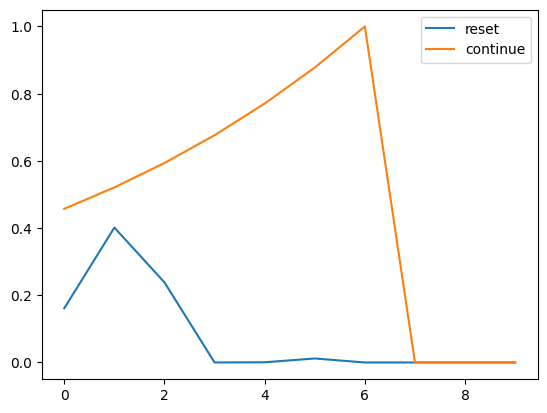

In [ ]:
plt.plot(gmats[0, 1, :10], label = 'reset')
plt.plot(gmats[0, 0, :10], label = 'continue')
plt.legend()

[<matplotlib.lines.Line2D>]

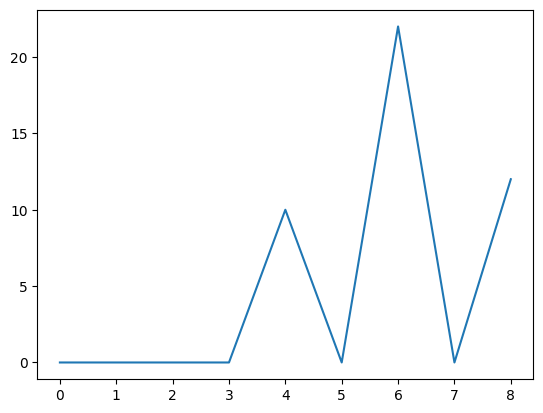

In [ ]:
plt.plot(np.bincount(np.array(counters).flatten()))

[<matplotlib.lines.Line2D>]

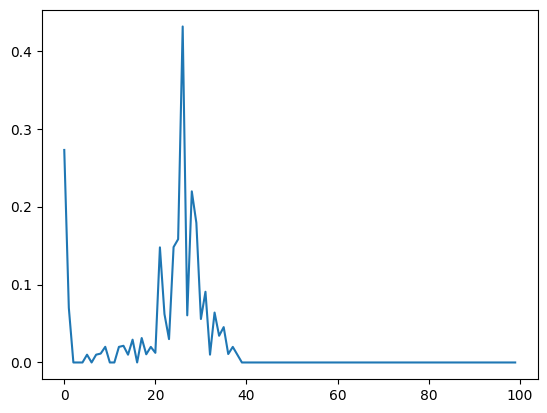

In [ ]:
plt.plot(gmats[-100:,1].mean(0))

[<matplotlib.lines.Line2D>]

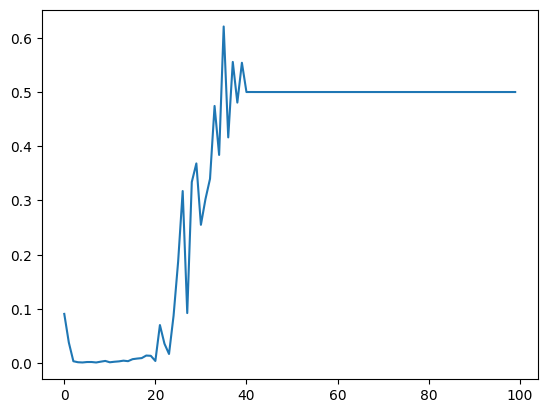

In [ ]:
plt.plot(agent.h_matrix[1]/agent.h_matrix.sum(0))

#### End test

In [ ]:
#| export
@njit(parallel = True)
def run_agents_reset(episodes, time_ep, N_agents,
                       # Environment props
                       D = 1/2, L = 10.0, 
                       # Agent props
                       num_actions = 2,
                       size_state_space = np.array([100]),
                       gamma_damping = 0.00001,
                       eta_glow_damping = 0.1,
                       g_update = 's',
                       initial_prob_distr = np.array([[],[]]),
                       policy_type = 'standard', 
                       beta_softmax = 3,  
                       fixed_policy = np.array([[],[]]),
                       max_no_H_update = int(1e3),
                       h_mat_allT = False, 
                       reset_after_reward = True,
                       # When we want N_agent != number of max cores, we use this to make few runs
                       # over the selected number of cores, given by N_agents.
                       num_runs = None 
                      ):

    if num_runs is None:
        total_agents = N_agents
    else:
        total_agents = N_agents*num_runs
    
    save_rewards = np.zeros((total_agents, episodes))
    if h_mat_allT:
        save_h_matrix = np.zeros((total_agents, episodes, size_state_space.prod()))  
    else:        
        save_h_matrix = np.zeros((total_agents, 2, size_state_space.prod())) 

    # if N_agents is an integer, we consider that we run this at full cores
    if num_runs is None:
    
        for n_agent in prange(N_agents):
            
            agent = Forager_efficient(num_actions, size_state_space,
                                      gamma_damping, eta_glow_damping, 
                                      policy_type, beta_softmax,
                                      initial_prob_distr,fixed_policy,max_no_H_update,g_update)
            env = ResetEnv_1D(L, D)
            
            rews, mat = train_loop_reset(episodes, time_ep, agent, env, h_mat_allT, reset_after_reward)            
     
            # print(rews.shape, rews[0], rews[0].dtype)
            
            save_rewards[n_agent] = rews
            save_h_matrix[n_agent] = mat

    # If it is a list, the first number is the number of parallel agents and the second the 
    # times we run those parallel agents
    else:

        n_run = -1        
        for run in range(num_runs):
            n_run += 1
            for idxa in prange(N_agents):
            
                agent = Forager_efficient(num_actions, size_state_space,
                                          gamma_damping, eta_glow_damping, 
                                          policy_type, beta_softmax,
                                          initial_prob_distr,fixed_policy,max_no_H_update, g_update)
                env = ResetEnv_1D(L, D)
                
                rews, mat = train_loop_reset(episodes, time_ep, agent, env, h_mat_allT, reset_after_reward)            
                         
                save_rewards[idxa*num_runs+n_run] = rews
                save_h_matrix[idxa*num_runs+n_run] = mat
        
        
    return save_rewards, save_h_matrix

**Run test**

In [ ]:
# from rl_opts.rl_framework_numba import Forager_efficient, ResetEnv_1D, train_loop_reset

In [ ]:
rews, mats = run_agents_reset(5, 100, 5, L = 2, num_runs=2, eta_glow_damping=0);

In [ ]:
rews

array([[0.01, 0.06, 0.04, 0.04, 0.03],
       [0.  , 0.01, 0.02, 0.03, 0.04],
       [0.03, 0.06, 0.05, 0.07, 0.02],
       [0.05, 0.  , 0.02, 0.02, 0.04],
       [0.03, 0.03, 0.  , 0.01, 0.01],
       [0.06, 0.06, 0.02, 0.02, 0.03],
       [0.02, 0.01, 0.03, 0.01, 0.03],
       [0.01, 0.03, 0.03, 0.06, 0.03],
       [0.01, 0.02, 0.01, 0.02, 0.04],
       [0.05, 0.04, 0.03, 0.  , 0.02]])

### 2D
We need to have the 2D as a separate function because of an unification problem of `numba`. You can't have the following, because it fails to properly compile, `env_1d` and `env_2d` have different variables and are then different objects.

```
if dim == 1:
    env = env_1d
else:
    env = env_2d
```

In [ ]:
#| export
@njit(parallel = True)
def run_agents_reset_2D(episodes, time_ep, N_agents,
                     # Environment props
                     dist_target = 10.0, radius_target = 1.0, D = 1/2,
                     # Agent props
                     num_actions = 2,
                     size_state_space = np.array([100]),
                     gamma_damping = 0.00001,
                     eta_glow_damping = 0.1,
                     initial_prob_distr = np.array([[],[]]),
                     policy_type = 'standard', 
                     beta_softmax = 3,  
                     fixed_policy = np.array([[],[]]),
                     max_no_H_update = int(1e3),
                     h_mat_allT = False, when_save_h_mat = 1,
                     reset_after_reward = True,
                     g_update = 's'                        
                      ):
    
    save_rewards = np.zeros((N_agents, episodes))
    if h_mat_allT:
        save_h_matrix = np.zeros((N_agents, 
                                  int(np.ceil(episodes/when_save_h_mat)), 
                                  size_state_space.prod()))  
    else:        
        save_h_matrix = np.zeros((N_agents, 2, size_state_space.prod())) 
    
    for n_agent in prange(N_agents):
        
        agent = Forager_efficient(num_actions, size_state_space,
                                  gamma_damping, eta_glow_damping, 
                                  policy_type, beta_softmax,
                                  initial_prob_distr,fixed_policy,max_no_H_update,g_update)
        
        env = ResetEnv_2D(dist_target, radius_target, D)
        
        rews, mat = train_loop_reset(episodes, time_ep, agent, env, h_mat_allT, when_save_h_mat, reset_after_reward)            
 
    
        save_rewards[n_agent] = rews
        save_h_matrix[n_agent] = mat
        
    return save_rewards, save_h_matrix

### Testing

In [ ]:
# from rl_opts.rl_framework_numba import Forager_efficient, ResetEnv_2D

In [ ]:
run_agents_reset_2D(int(1e2),int(1e2), 15, dist_target = 10, radius_target = 1, D = 1, 
                           size_state_space=np.array([3]),
                          h_mat_allT=True, when_save_h_mat=5);

In [ ]:
h.shape

(15, 20, 3)

In [ ]:
np.unique(r.flatten(), return_counts=True)

(array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
        0.009]),
 array([47569, 53276, 31957, 12400,  3745,   844,   173,    32,     3,
            1]))

[<matplotlib.lines.Line2D>]

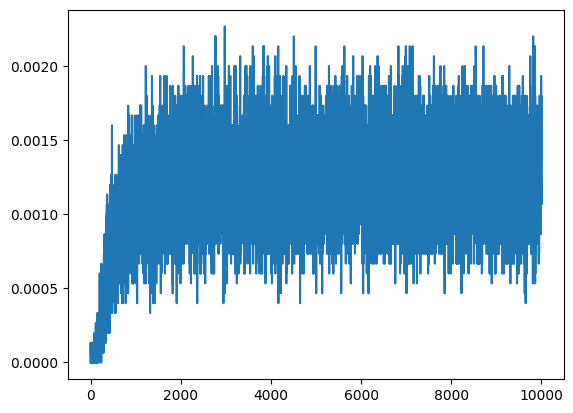

In [ ]:
pol = []
for ha in h:
    pol.append(ha[0]/ha.sum(0))
pol = np.array(pol)

plt.plot(r.mean(0))

[<matplotlib.lines.Line2D>]

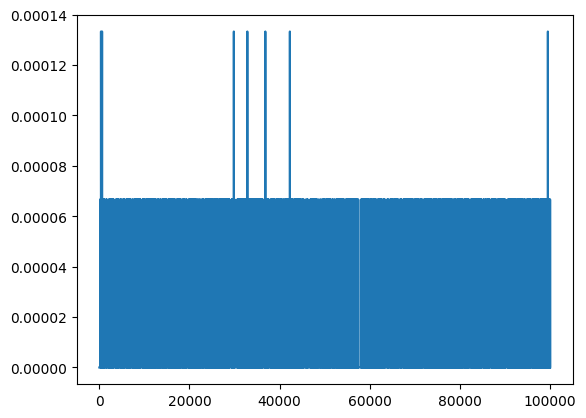

In [ ]:
plt.plot(r.mean(0))

## For MoveResetEnv

### 2D

#### For base env

In [ ]:
#| export
@njit(parallel = True)
def train_loop_MoveReset2D(episodes, time_ep, agent, env, h_mat_allT = False, turn_0_when_reset = False):  

    if h_mat_allT: policy_t = np.zeros((episodes, agent.h_matrix.shape[-1]))
    save_rewards = np.zeros(episodes)

    for ep in range(episodes):
        # print(f'starting episode {ep} for agent {n_agent}')
        #initialize environment and agent's counter and g matrix
        env.init_env()

        # We treat counters as external variables because Numba does allow to
        # add attributes to defined object
        direction_counter = 0
        reset_counter = 0

        agent.reset_g()

        for t in range(time_ep):

            # Update counters for matrices updates
            agent.N_upd_H += 1
            agent.N_upd_G += 1

            # We add a checkpoint in case the counters are bigger than the state_size.
            # This is needed because often the time_ep is bigger than the state_size. While
            # it usually uncommon that we reach the max state_size, doing so breaks the program.
            # Instead, if we reach the maximum we just reset the counters
            if direction_counter == agent.size_state_space[0]-1:
                direction_counter = 0                
            if reset_counter == agent.size_state_space[1]-1:
                reset_counter = 0      

                
            #get perception
            state = np.array([direction_counter, reset_counter])
            #decide
            action = agent.deliberate(state)
                
            # Act (this substitutes agent.act)
            if action == 0: # continue
                direction_counter += 1  
                reset_counter += 1 
            elif action == 1: # turn
                direction_counter = 0  
                reset_counter += 1 
            elif action == 2: # reset
                if turn_0_when_reset:
                    direction_counter = 0
                else:
                    direction_counter += 1  
                reset_counter = 0 
                
            
            #update positions
            reward = env.update_pos(True if action == 1 else False, True if action == 2 else False)

            if reward == 1:
                
                agent._learn_post_reward(reward)
                
                # After receiving a reward, we also reset the counters
                direction_counter = 0
                reset_counter = 0                

            if agent.N_upd_H == agent.max_no_H_update-1:
                agent._learn_post_reward(reward)
                    
            # Saving
            save_rewards[ep] += reward
            
        if h_mat_allT: policy_t[ep] = agent.h_matrix[0,:] / agent.h_matrix.sum(0)
    return (save_rewards, policy_t) if h_mat_allT else (save_rewards, agent.h_matrix)

In [ ]:
# from rl_opts.rl_framework_numba import Forager_efficient, MoveResetEnv_2D

In [ ]:
agent = Forager_efficient(num_actions = 3, size_state_space = np.array([100, 100]),
                          gamma_damping = np.array([1e-5]*3),
                          eta_glow_damping = np.array([0.1,0.1,0.1]),
                          max_no_H_update = 10)
env = MoveResetEnv_2D(dist_target = 5.1, # Distance from init position and target
                      radius_target = 1.0, # Radius of the target
                      agent_step = 1)

In [ ]:
rews, hmat = train_loop_MoveReset2D(episodes = 100, time_ep = int(1e4), agent = agent, env = env, h_mat_allT = False, turn_0_when_reset=True)
# hmat

##### Normal h_matrix update

In [ ]:
#| export
@njit(parallel = True)
def run_agents_MoveReset2D(episodes, time_ep, N_agents,
                         # Environment props
                           dist_target = 5.1, # Distance from init position and target
                           radius_target = 1.0, # Radius of the target
                           agent_step = 1.0,
                           # Agent props
                           num_actions = 3,
                           size_state_space = np.array([100, 100]),  
                           gamma_damping = 0.00001,
                           eta_glow_damping = 0.1,
                           initial_prob_distr = np.array([[],[]]),
                           policy_type = 'standard', 
                           beta_softmax = 3,  
                           fixed_policy = np.array([[],[]]),
                           max_no_H_update = int(1e3),
                           efficient_agent = False,
                           h_mat_allT = False
                        ):

    save_rewards = np.zeros((N_agents, episodes))
    if h_mat_allT:
        save_h_matrix = np.zeros((N_agents, episodes, int(np.prod(size_state_space))))  
    else:        
        save_h_matrix = np.zeros((N_agents, num_actions, int(np.prod(size_state_space)))) 
    
    for n_agent in prange(N_agents):
        
        env = MoveResetEnv_2D(dist_target, radius_target, agent_step)
       
        agent = Forager_efficient(num_actions,size_state_space,gamma_damping,
                                  eta_glow_damping,policy_type,beta_softmax,
                                  initial_prob_distr,fixed_policy,max_no_H_update)
        
        rews, mat = train_loop_MoveReset2D(episodes, time_ep, agent, env, h_mat_allT) 
    
        save_rewards[n_agent] = rews
        save_h_matrix[n_agent] = mat
        
    return save_rewards, save_h_matrix

In [ ]:
r, h = run_agents_MoveReset2D(episodes = 1000, time_ep = 1000, N_agents = 10)

In [ ]:
h.shape

(10, 3, 10000)

Text(0.5, 0, 'Reset counter')

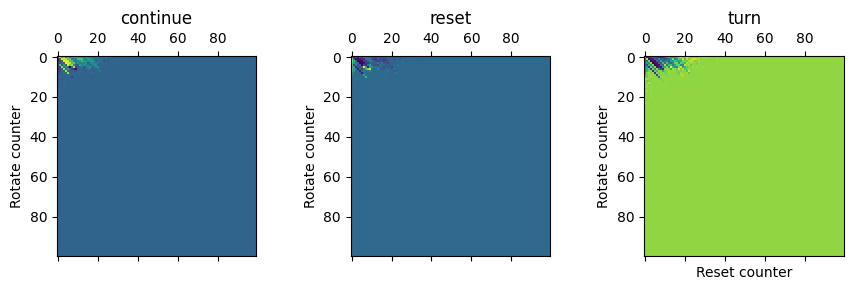

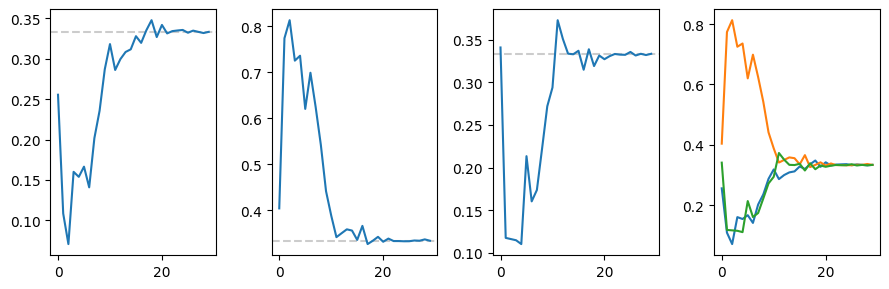

In [ ]:
mat = h.mean(0)
size_state_space = (100, 100)

fig, ax = plt.subplots(1, 3, figsize = (9, 3), tight_layout = True)
_, ax2 = plt.subplots(1, 4, figsize = (9, 3), tight_layout = True)
for i, action in enumerate(['continue', 'reset', 'turn']):
    
    ax[i].matshow((mat[i]/mat.sum(0)).reshape(size_state_space).transpose())
    ax[i].set_ylabel('Rotate counter')
    ax[i].set_title(action)

    ax2[i].plot((mat[i]/mat.sum(0))[:30])
    ax2[i].axhline(1/3, c = 'k', ls = '--', alpha = 0.2, zorder = -1)
    ax2[-1].plot((mat[i]/mat.sum(0))[:30])
    
ax[-1].set_xlabel('Reset counter')

[<matplotlib.lines.Line2D>]

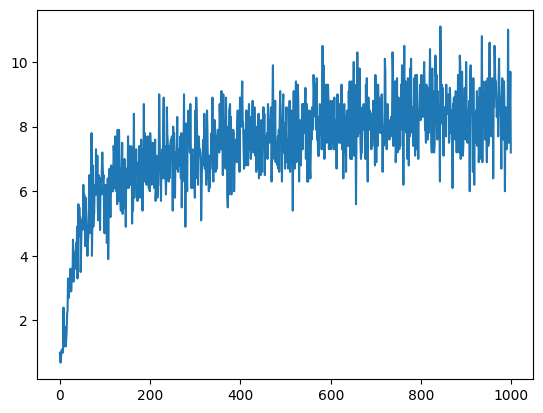

In [ ]:
plt.plot(r.mean(0))

##### Multi param h_matrix update

In [ ]:
 gamma_damping = 0.00001,
                           eta_glow_damping = 0.1,

In [ ]:
gamma_damping = np.array([1e-5,2e-5, 3e-5])
eta_glow_damping = np.array([0.1, 0.2, 0.3])

assert gamma_damping.shape[0] == 3 and eta_glow_damping.shape[0] == 3, "

In [ ]:
#| export
@njit(parallel = True)
def run_agents_MoveReset2D_multiparam(episodes, time_ep, N_agents,
                         # Environment props
                           dist_target = 5.1, # Distance from init position and target
                           radius_target = 1.0, # Radius of the target
                           agent_step = 1.0,
                           # Agent props
                           num_actions = 3,
                           size_state_space = np.array([100, 100]),  
                           gamma_damping = np.array([1e-5,2e-5, 3e-5]),
                           eta_glow_damping = np.array([0.1, 0.2, 0.3]),
                           initial_prob_distr = np.array([[],[]]),
                           policy_type = 'standard', 
                           beta_softmax = 3,  
                           fixed_policy = np.array([[],[]]),
                           max_no_H_update = int(1e3),
                           efficient_agent = False,
                           h_mat_allT = False,
                           turn_0_when_reset = False
                        ):

    assert gamma_damping.shape[0] == num_actions and gamma_damping.shape[0] == num_actions, "Params should be of same size as the number of actions"

    save_rewards = np.zeros((N_agents, episodes))
    if h_mat_allT:
        save_h_matrix = np.zeros((N_agents, episodes, int(np.prod(size_state_space))))  
    else:        
        save_h_matrix = np.zeros((N_agents, num_actions, int(np.prod(size_state_space)))) 
    
    for n_agent in prange(N_agents):
        
        env = MoveResetEnv_2D(dist_target, radius_target, agent_step)
       
        agent = Forager_multi_param(num_actions,size_state_space,gamma_damping,
                                    eta_glow_damping,policy_type,beta_softmax,
                                    initial_prob_distr,fixed_policy,max_no_H_update)
        
        rews, mat = train_loop_MoveReset2D(episodes, time_ep, agent, env, h_mat_allT, turn_0_when_reset) 
    
        save_rewards[n_agent] = rews
        save_h_matrix[n_agent] = mat
        
    return save_rewards, save_h_matrix

In [ ]:
# from rl_opts.rl_framework_numba import Forager_multi_param, train_loop_MoveReset2D

In [ ]:
r, h = run_agents_MoveReset2D_multiparam(episodes = 1000, time_ep = 1000, N_agents = 10)

In [ ]:
h.shape

(10, 3, 10000)

Text(0.5, 0, 'Reset counter')

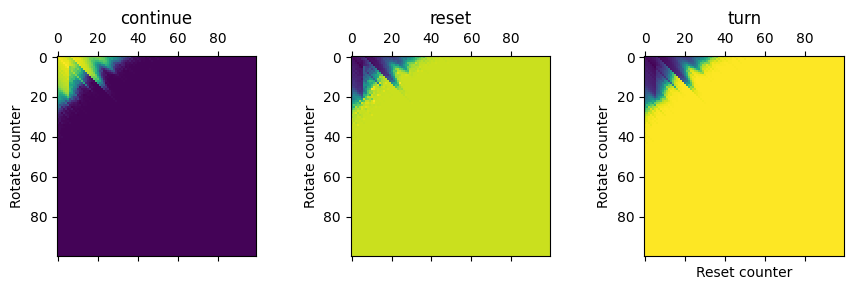

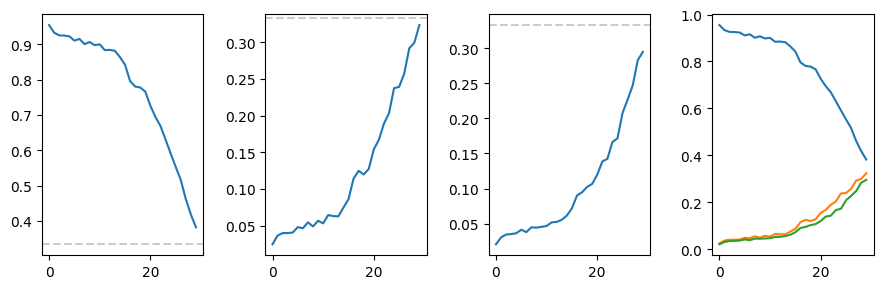

In [ ]:
mat = h.mean(0)
size_state_space = (100, 100)

fig, ax = plt.subplots(1, 3, figsize = (9, 3), tight_layout = True)
_, ax2 = plt.subplots(1, 4, figsize = (9, 3), tight_layout = True)
for i, action in enumerate(['continue', 'reset', 'turn']):
    
    ax[i].matshow((mat[i]/mat.sum(0)).reshape(size_state_space).transpose())
    ax[i].set_ylabel('Rotate counter')
    ax[i].set_title(action)

    ax2[i].plot((mat[i]/mat.sum(0))[:30])
    ax2[i].axhline(1/3, c = 'k', ls = '--', alpha = 0.2, zorder = -1)
    ax2[-1].plot((mat[i]/mat.sum(0))[:30])
    
ax[-1].set_xlabel('Reset counter')

[<matplotlib.lines.Line2D>]

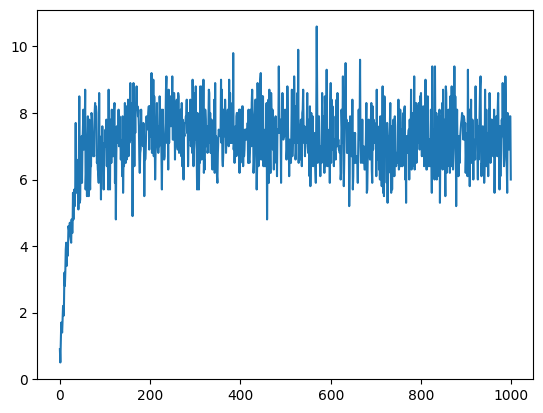

In [ ]:
plt.plot(r.mean(0))

#### For others

In [ ]:
#| export
@njit(parallel = True)
def train_loop_MoveReset(episodes, time_ep, agent, env, h_mat_allT = False):  

    if h_mat_allT: policy_t = np.zeros((episodes, agent.h_matrix.shape[-1]))
    save_rewards = np.zeros(episodes)


    for ep in range(episodes):
        # print(f'starting episode {ep} for agent {n_agent}')
        #initialize environment and agent's counter and g matrix
        env.init_env()

        # We treat counters as external variables because Numba does allow to
        # add attributes to defined object
        direction_counter = 0
        reset_counter = 0

        agent.reset_g()

        for t in range(time_ep):

            # Update counters for matrices updates
            agent.N_upd_H += 1
            agent.N_upd_G += 1

            # Step to set counter to its min value n=1
            if t == 0 or env.kicked[0]:
                # do one step with random direction (no learning in this step)
                env.update_pos(True, False)
                #check boundary conditions
                env.check_bc()

                # Reset counter
                direction_counter = 0
                #set kicked value to false again
                env.kicked[0] = 0
                reward = 0

            else:
                # We add a checkpoint in case the counters are bigger than the state_size.
                # This is needed because often the time_ep is bigger than the state_size. While
                # it usually uncommon that we reach the max state_size, doing so breaks the program.
                # Instead, if we reach the maximum we just reset the counters
                if direction_counter == agent.size_state_space[0]-1:
                    direction_counter = 0                
                if reset_counter == agent.size_state_space[1]-1:
                    reset_counter = 0      

                
                #get perception
                state = np.array([direction_counter, reset_counter])
                #decide
                action = agent.deliberate(state)
                
                # Act (this substitutes agent.act)
                if action == 0: # continue
                    direction_counter += 1  
                    reset_counter += 1 
                elif action == 1: # turn
                    direction_counter = 0  
                    reset_counter += 1 
                elif action == 2: # reset
                    direction_counter += 1  
                    reset_counter = 0 

                #update positions
                env.update_pos(change_direction = True if action == 1 else False, reset = True if action == 2 else False)

                if action == 2:
                    env.previous_pos = env.init_positions.copy()
                    
                #check if target was found + kick if it is
                reward = env.check_encounter()
                #check boundary conditions
                env.check_bc()
                #learn
                if reward == 1:
                    agent._learn_post_reward(reward)       
            
            

            if agent.N_upd_H == agent.max_no_H_update-1:
                    agent._learn_post_reward(reward)
                    
            # Saving
            save_rewards[ep] += reward
            
        if h_mat_allT: policy_t[ep] = agent.h_matrix[0,:] / agent.h_matrix.sum(0)
    
    return (save_rewards, policy_t) if h_mat_allT else (save_rewards, agent.h_matrix)

In [ ]:
#| export
@njit(parallel = True)
def run_agents_MoveReset(episodes, time_ep, N_agents,
                         # Environment props
                         Nt = 100,
                         L = 100,
                         r = 0.5,
                         lc = np.array([[1.0],[1]]),
                         num_agents = 1, 
                         agent_step = 1,
                         destructive_targets = False,
                         lc_distribution = 'constant',
                         init_positions = np.array([[0.0, 0.0]]),
                         # Agent props
                         num_actions = 2,
                         size_state_space = np.array([100, 100]),
                         gamma_damping = 0.00001,
                         eta_glow_damping = 0.1,
                         initial_prob_distr = np.array([[],[]]),
                         policy_type = 'standard', 
                         beta_softmax = 3,  
                         fixed_policy = np.array([[],[]]),
                         max_no_H_update = int(1e3),
                         efficient_agent = False,
                         h_mat_allT = False
                        ):

    save_rewards = np.zeros((N_agents, episodes))
    if h_mat_allT:
        save_h_matrix = np.zeros((N_agents, episodes, int(np.prod(size_state_space))))  
    else:        
        save_h_matrix = np.zeros((N_agents, num_actions, int(np.prod(size_state_space)))) 
    
    for n_agent in prange(N_agents):
        
        env = MoveResetEnv(Nt,L,r,lc,agent_step,num_agents,destructive_targets,lc_distribution,init_positions)
       
        agent = Forager_efficient(num_actions,size_state_space,gamma_damping,
                                  eta_glow_damping,policy_type,beta_softmax,
                                  initial_prob_distr,fixed_policy,max_no_H_update)
        
        rews, mat = train_loop_MoveReset(episodes, time_ep, agent, env, h_mat_allT) 
    
        save_rewards[n_agent] = rews
        save_h_matrix[n_agent] = mat
        
    return save_rewards, save_h_matrix

In [ ]:
#### For compiling and checking
rews , mats = run_agents_MoveReset(episodes = int(1e2), time_ep = int(1e3), num_actions = 3,
                                N_agents = 1, size_state_space = np.array([10, 10]), 
                                efficient_agent=False, init_positions = np.array([[10, 10.1]]));

In [ ]:
rews


array([[ 4.,  0.,  1., 16.,  1.,  0.,  0.,  1.,  0.,  4.,  0.,  4.,  0.,
        13.,  0.,  1.,  2.,  0.,  0.,  0., 11., 30.,  6.,  0., 12.,  7.,
        11.,  4.,  6.,  2.,  2.,  5.,  4.,  4.,  5.,  0.,  0., 29.,  2.,
         6.,  2.,  2., 10.,  0.,  4.,  2.,  0.,  0., 15., 46.,  2.,  3.,
         0.,  0., 15.,  0.,  1.,  6.,  3.,  4.,  3., 13.,  2.,  2.,  4.,
         4.,  0.,  8.,  0.,  2.,  2.,  3.,  4.,  5.,  4.,  2.,  3., 14.,
         2., 32.,  0., 17.,  7., 26.,  3.,  2.,  2.,  0.,  2.,  6.,  0.,
         4.,  8.,  0.,  3.,  1., 26.,  3.,  3.,  5.]])

In [ ]:
%timeit run_agents_MoveReset(episodes = int(1e2), time_ep = int(1e2), num_actions = 3, N_agents = 10, size_state_space = np.array([500, 500]), init_positions = np.array([[10, 10.1]]));

#### How to read the h-matrix:

In [ ]:
agent = Forager_efficient(num_actions = 3, size_state_space = np.array([100, 100]))

Convoluted way of doing it (see below for better option):

In [ ]:
size_state_space = np.array([100, 100])
mat_2d = np.zeros(size_state_space)
for c_rotate in range(size_state_space[0]):
    for c_reset in range(size_state_space[1]):
        mat_2d[c_rotate, c_reset] = (mat[0]/mat.sum(0))[agent.percept_preprocess(np.array([c_rotate, c_reset]))]

Text(0.5, 0, 'Reset counter')

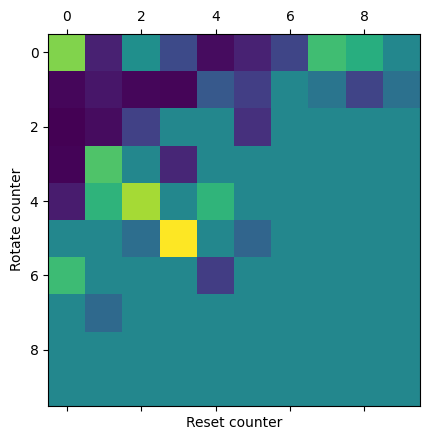

In [ ]:
plt.matshow(mat_2d[:10, :10])
plt.ylabel('Rotate counter')
plt.xlabel('Reset counter')

Better way: reshape + tranpose!!

In [ ]:
mat = mats[0]

Text(0.5, 0, 'Reset counter')

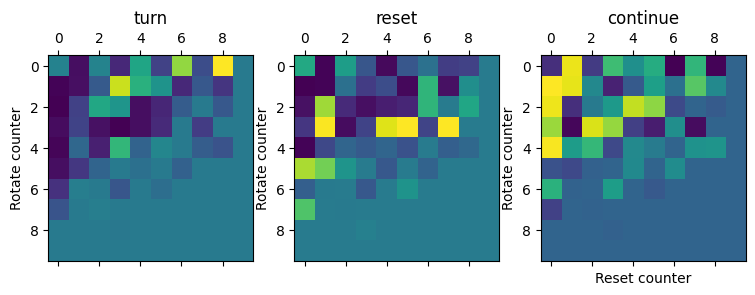

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (9, 3))
for i, action in enumerate(['turn', 'reset', 'continue']):
    
    ax[i].matshow((mat[i]/mat.sum(0)).reshape(10,10).transpose()[:10,:10])
    ax[i].set_ylabel('Rotate counter')
    ax[i].set_title(action)
    
ax[-1].set_xlabel('Reset counter')

# nbdev

In [ ]:
#| hide
from nbdev import nbdev_export ; nbdev_export()